<a href="https://colab.research.google.com/github/Payal2000/Data-Science-Assignments-INFO6105/blob/main/Assignment_2_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 2- Breast Cancer Prediction using H2O Auto ML

# **Abstract**
## What is our ultimate aim with this notebook?

Our ultimate aim is to build a machine learning model using H2O Auto ML that can predict if the person is suffering from Breast Cancer Prediction based on several medical parameters as mentioned below.

# **Background**

This project is centered around **breast cancer**, the most prevalent cancer among women worldwide, impacting over 2.1 million people in 2015 alone. The condition is characterized by uncontrolled breast cell growth, leading to the formation of tumors visible via X-ray or as palpable lumps.

The critical dataset for this analysis, containing extensive parameters for breast cancer diagnosis, is sourced from Kaggle.

The datasets consists of several medical predictor variables and one target variable, diagnosis with classes such as M (malignant) or B (benign)

### **Column Description for our Dataset**

Kaggle Dataset Link: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset

Predictor variables includes : All variables except for the diagnosis are predictor variables.

###**Column Description for Breast Cancer Detection Dataset:**

- **id:** Unique identifier for each patient or observation.
- **diagnosis:** The diagnosis of breast tissues. M: Malignant - Indicates cancerous tumors. B: Benign - Indicates non-cancerous tumors.
- radius_mean: Mean of distances from the center to points on the perimeter of the tumor.
- **texture_mean:** Standard deviation of gray-scale values, which can give an indication of the texture or smoothness of the tumor.
- **perimeter_mean:** Mean size of the core tumor.
- **area_mean:** Mean area covered by the tumor.
- **smoothness_mean:** Mean of the local variation in radius lengths.
- **compactness_mean:** Mean of the perimeter^2 / area - 1.0.
- **concavity_mean:** Mean of the severity of concave portions of the contour of the tumor.
- **concave points_mean:** Mean number of concave portions of the contour.
- **symmetry_mean:** Mean symmetry of the tumor.
- **fractal_dimension_mean:** It gives an indication of how the shape of the tumor deviates from a simple shape.

The columns with the worst suffix (like radius_worst, texture_worst, etc.) provide the worst or largest mean value for each feature, derived from an average of three largest values.

#**What is Auto ML?**

Automated Machine Learning (AutoML) is the process of automating tasks in the machine learning pipeline such as data preprocessing, hyperparameter tuning, model selection and evaluation. AutoML tends to automate the maximum number of steps in an ML pipeline — with a minimum amount of human effort — without compromising the model’s performance.In this notebook we will examine how to utilize open source automated machine learning package from H2O to accelerate model development process.



## **Setup**

### Let’s import the necessary packages

In [ ]:
##Installing all the required libraries for the Assignment
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.1-py2.py3-none-any.whl size=257484150 sha256=d7c381c1d518149c93cfe03d6a7aeac62a63c4a30a8ce34e7b054c019fa8cc0b
  Stored in directory: /root/.cache/pip/wheels/d9/9b/ca/7345b72d17e1e17da37239d70631c3214ec9e541b0c9e700e2
Successfully built h2o


In [ ]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (16, 8)})

Description of few important libraries

1. **h2o** - h2o is a fast, open-source, in-memory, distributed, advanced analytics and modeling engine. It supports GLMs, gradient boosting, random forests, deep learning, and automatic machine learning.

2. **pprint** is a library for pretty-printing data structures.

3. **operator** provides functions to perform operations on sequences, such as sorting.

4. **matplotlib** is a plotting library for creating charts, graphs, and other visualizations.

5. **tabulate** is a library for creating tables in various formats.

6. **logging** is a library for emitting log messages from applications.

7. **optparse** is a library for parsing command-line options.

8. **psutil** is a library for retrieving information on system utilization (CPU, memory, disks, network, sensors) and on running processes and system uptime.

In [ ]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

### **Why do we have to set runtime?**

The value set for the maximum runtime in AutoML will depend on a variety of factors, including the size and complexity of your dataset, the number of models and hyperparameters you want to explore, and the computational resources available to you.Setting a runtime limit is an important for managing resources and optimizing the efficiency of the machine learning process in AutoML Also you can change the runtime values and check the model performance

**min_mem_size = 6** typically refers to the minimum amount of memory (in gigabytes) that is required to run a particular software or process. It means that the system running the software or process must have at least 6 GB of available memory in order to run it without encountering memory-related issues.

In [ ]:
#Calculating the minimum amount of memeory required
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


Note :psutil library is used to retrieve system information, and must be installed

## **Initialize the H2O cluster**

In [ ]:
# 65535 Highest port no
#generating a random port number between 5555 and 55555, which will be used to start the H2O server
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:17794..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpe04p7tij
  JVM stdout: /tmp/tmpe04p7tij/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpe04p7tij/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:17794
Connecting to H2O server at http://127.0.0.1:17794 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         08 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.1
H2O_cluster_version_age:    16 days
H2O_cluster_name:           H2O_from_python_unknownUser_vppcej
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:17794
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

The parameter strict_version_check is used to control whether H2O performs strict version checking between the H2O client and server. If strict_version_check=True, H2O will check whether the versions of the H2O client and server match exactly, and will raise an error if they don't. If strict_version_check=False, H2O will perform a more lenient version check, allowing minor version mismatches.



In [ ]:
# Reading CSV file into Pandas DataFrame
pandas_df = pd.read_csv(
    "https://raw.githubusercontent.com/Payal2000/Data-Science-Assignments-INFO6105/main/new_model.csv"
)

## **Performing EDA**

In [ ]:
#Printing the summary of the dataframe for our Analysis like data types,null values and memory usage
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
#Checking missing values in our data
pandas_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

## Observations:

We have 0% missing values both in our independent variables as well as dependent variable

In [ ]:
# Printing Shape of the dataframe
pandas_df.shape

(569, 32)

The .shape attribute of a pandas DataFrame provides the dimensions of the DataFrame in the form of a tuple.

- 569 rows: This suggests that there are 569 entries or records in the DataFrame.
- 32 columns: This indicates that there are 32 features or variables for each sample in the DataFrame.

In [ ]:
#Reading first 5 rows of data frame
pandas_df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [ ]:
# Printing the name of all predictors and result
columns = list(pandas_df.columns)
print(columns)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [ ]:
# Statistical description of our dataset
pandas_df.describe()

id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

In [68]:
#Calculating correlation matrix for all variables
pandas_df.corr()

id  diagnosis  radius_mean  texture_mean  \
id                       1.000000   0.039769     0.074626      0.099770   
diagnosis                0.039769   1.000000     0.730029      0.415185   
radius_mean              0.074626   0.730029     1.000000      0.323782   
texture_mean             0.099770   0.415185     0.323782      1.000000   
perimeter_mean           0.073159   0.742636     0.997855      0.329533   
area_mean                0.096893   0.708984     0.987357      0.321086   
smoothness_mean         -0.012968   0.358560     0.170581     -0.023389   
compactness_mean         0.000096   0.596534     0.506124      0.236702   
concavity_mean           0.050080   0.696360     0.676764      0.302418   
concave_points_mean      0.044158   0.776614     0.822529      0.293464   
symmetry_mean           -0.022114   0.330499     0.147741      0.071401   
fractal_dimension_mean  -0.052511  -0.012838    -0.311631     -0.076437   
radius_se                0.143048   0.567134     0.679090      0.275869   
texture_se              -0.007526  -0.008303    -0.097317      0.386358   
perimeter_se             0.137331   0.556141     0.674172      0.281673   
area_se                  0.177742   0.548236     0.735864      0.259845   
smoothness_se            0.096781  -0.067016    -0.222600      0.006614   
compactness_se           0.033961   0.292999     0.206000      0.191975   
concavity_se             0.055239   0.253730     0.194204      0.143293   
concave_points_se        0.078768   0.408042     0.376169      0.163851   
symmetry_se             -0.017306  -0.006522    -0.104321      0.009127   
fractal_dimension_se     0.025725   0.077972    -0.042641      0.054458   
radius_worst             0.082405   0.776454     0.969539      0.352573   
texture_worst            0.064720   0.456903     0.297008      0.912045   
perimeter_worst          0.079986   0.782914     0.965137      0.358040   
area_worst               0.107187   0.733825     0.941082      0.343546   
smoothness_worst         0.010338   0.421465     0.119616      0.077503   
compactness_worst       -0.002968   0.590998     0.413463      0.277830   
concavity_worst          0.023203   0.659610     0.526911      0.301025   
concave_points_worst     0.035174   0.793566     0.744214      0.295316   
symmetry_worst          -0.044224   0.416294     0.163953      0.105008   
fractal_dimension_worst -0.029866   0.323872     0.007066      0.119205   

                         perimeter_mean  area_mean  smoothness_mean  \
id                             0.073159   0.096893        -0.012968   
diagnosis                      0.742636   0.708984         0.358560   
radius_mean                    0.997855   0.987357         0.170581   
texture_mean                   0.329533   0.321086        -0.023389   
perimeter_mean                 1.000000   0.986507         0.207278   
area_mean                      0.986507   1.000000         0.177028   
smoothness_mean                0.207278   0.177028         1.000000   
compactness_mean               0.556936   0.498502         0.659123   
concavity_mean                 0.716136   0.685983         0.521984   
concave_points_mean            0.850977   0.823269         0.553695   
symmetry_mean                  0.183027   0.151293         0.557775   
fractal_dimension_mean        -0.261477  -0.283110         0.584792   
radius_se                      0.691765   0.732562         0.301467   
texture_se                    -0.086761  -0.066280         0.068406   
perimeter_se                   0.693135   0.726628         0.296092   
area_se                        0.744983   0.800086         0.246552   
smoothness_se                 -0.202694  -0.166777         0.332375   
compactness_se                 0.250744   0.212583         0.318943   
concavity_se                   0.228082   0.207660         0.248396   
concave_points_se              0.407217   0.372320         0.380676   
symmetry_se                   -0.081629  -0.072497         0.200

<ipython-input-14-e55a2206e53a>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pandas_df.corr(), center=0, linewidths=0.8, cmap='GnBu',


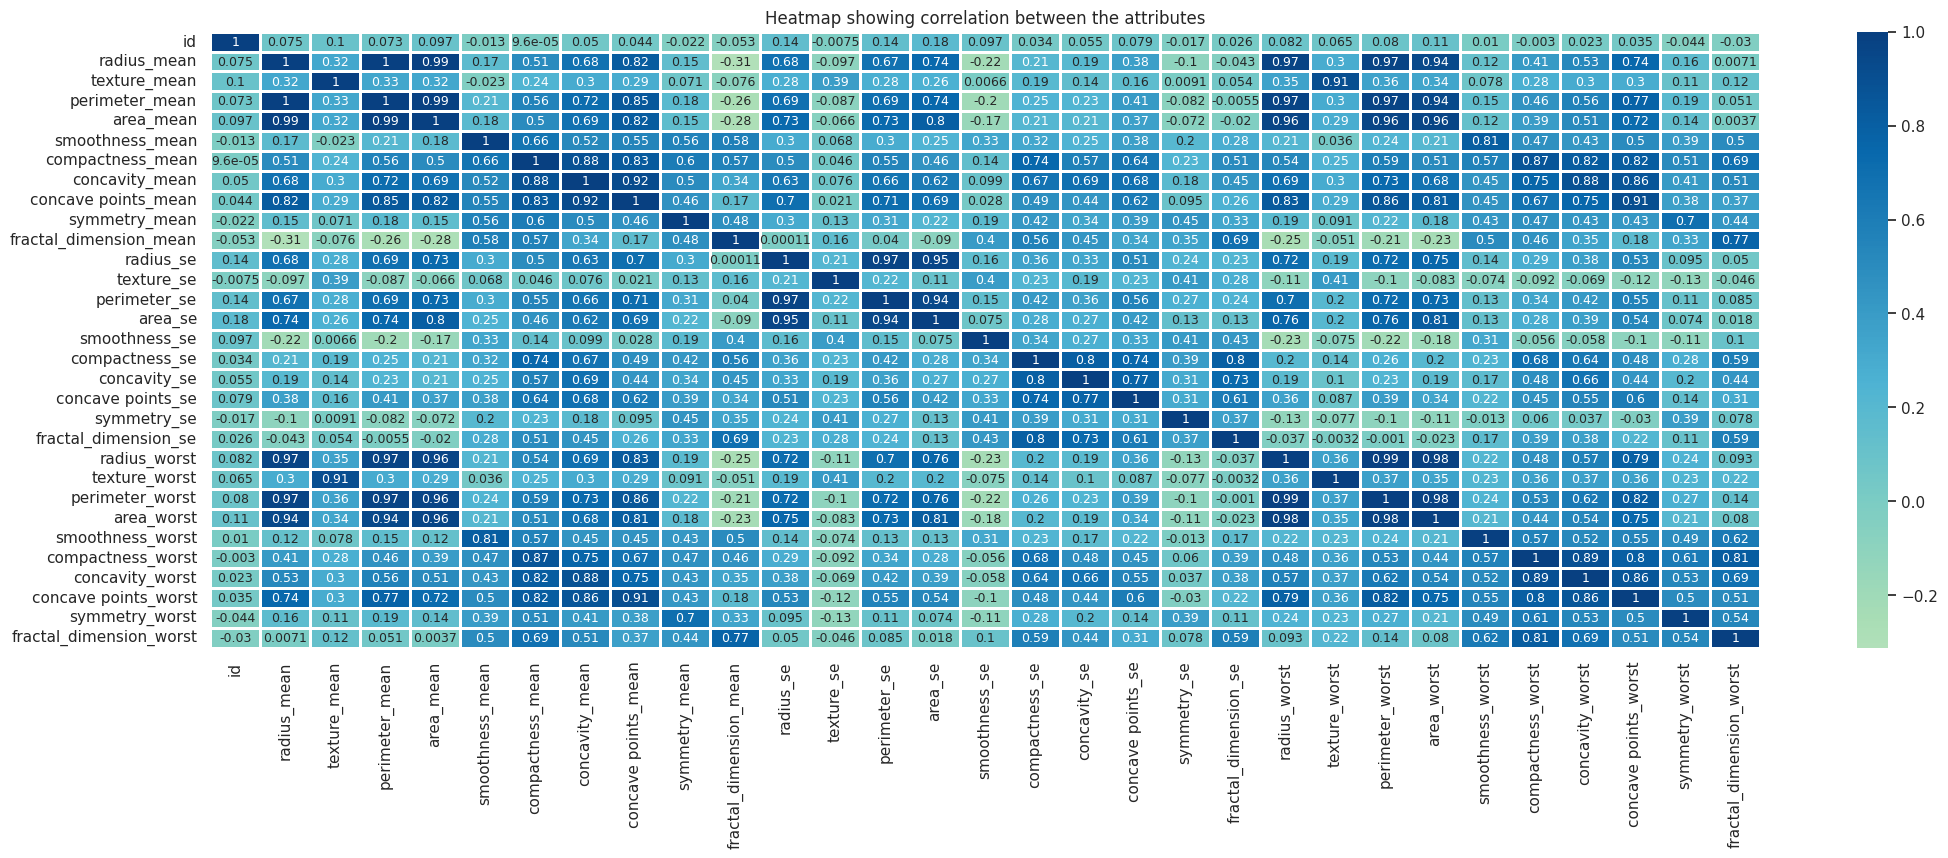

In [ ]:
# Importing the necessary libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Setting up the matplotlib figure and axes, and defining the figure size
f, ax = plt.subplots(figsize=(25, 8))

# Creating a heatmap for the correlation matrix of the pandas DataFrame
# Additional specifications include centering the colormap at 0, setting linewidths,
# using the 'coolwarm' colormap, adding annotations, and customizing annotation sizes.
sns.heatmap(pandas_df.corr(), center=0, linewidths=0.8, cmap='GnBu',
            annot=True, annot_kws={"size": 9}, ax=ax)

# Adding a title to the heatmap
plt.title('Heatmap showing correlation between the attributes')

# Displaying the heatmap
plt.show()


##**Observation:**

The heatmap visualizes the pairwise correlation between various breast cancer diagnostic attributes.

**Correlation Analysis:**

- From the plots, we do not have much high correlation between features.
- **perimeter_mean and area_mean** has the correlation value of **0.99**
- **texture_mean and radius_mean** has the correlation value of **0.32**
- **compactness_mean and smoothness_mean has the correlation of 0.6.**
- **radius_mean, perimeter_mean, and area_mean** have strong positive correlations, all exceeding **0.9.**
- Similarly, radius_worst, perimeter_worst, and area_worst display strong positive correlations, again all exceeding **0.9.**
- Attributes like compactness_mean, concavity_mean, and concave_points_mean show strong positive correlations, with values close to or exceeding **0.8.**
- In the "worst" category, compactness_worst, concavity_worst, and concave_points_worst also demonstrate strong positive correlations, nearing or above **0.8.**
- There are attributes with relatively low correlations, evident by values close to **0 or in the negative range.**
- **fractal_dimension_mean, fractal_dimension_se, and fractal_dimension_worst** generally have weaker correlations with other attributes.
- The presence of several high correlation values hints at multicollinearity, which could affect the robustness of certain statistical models.



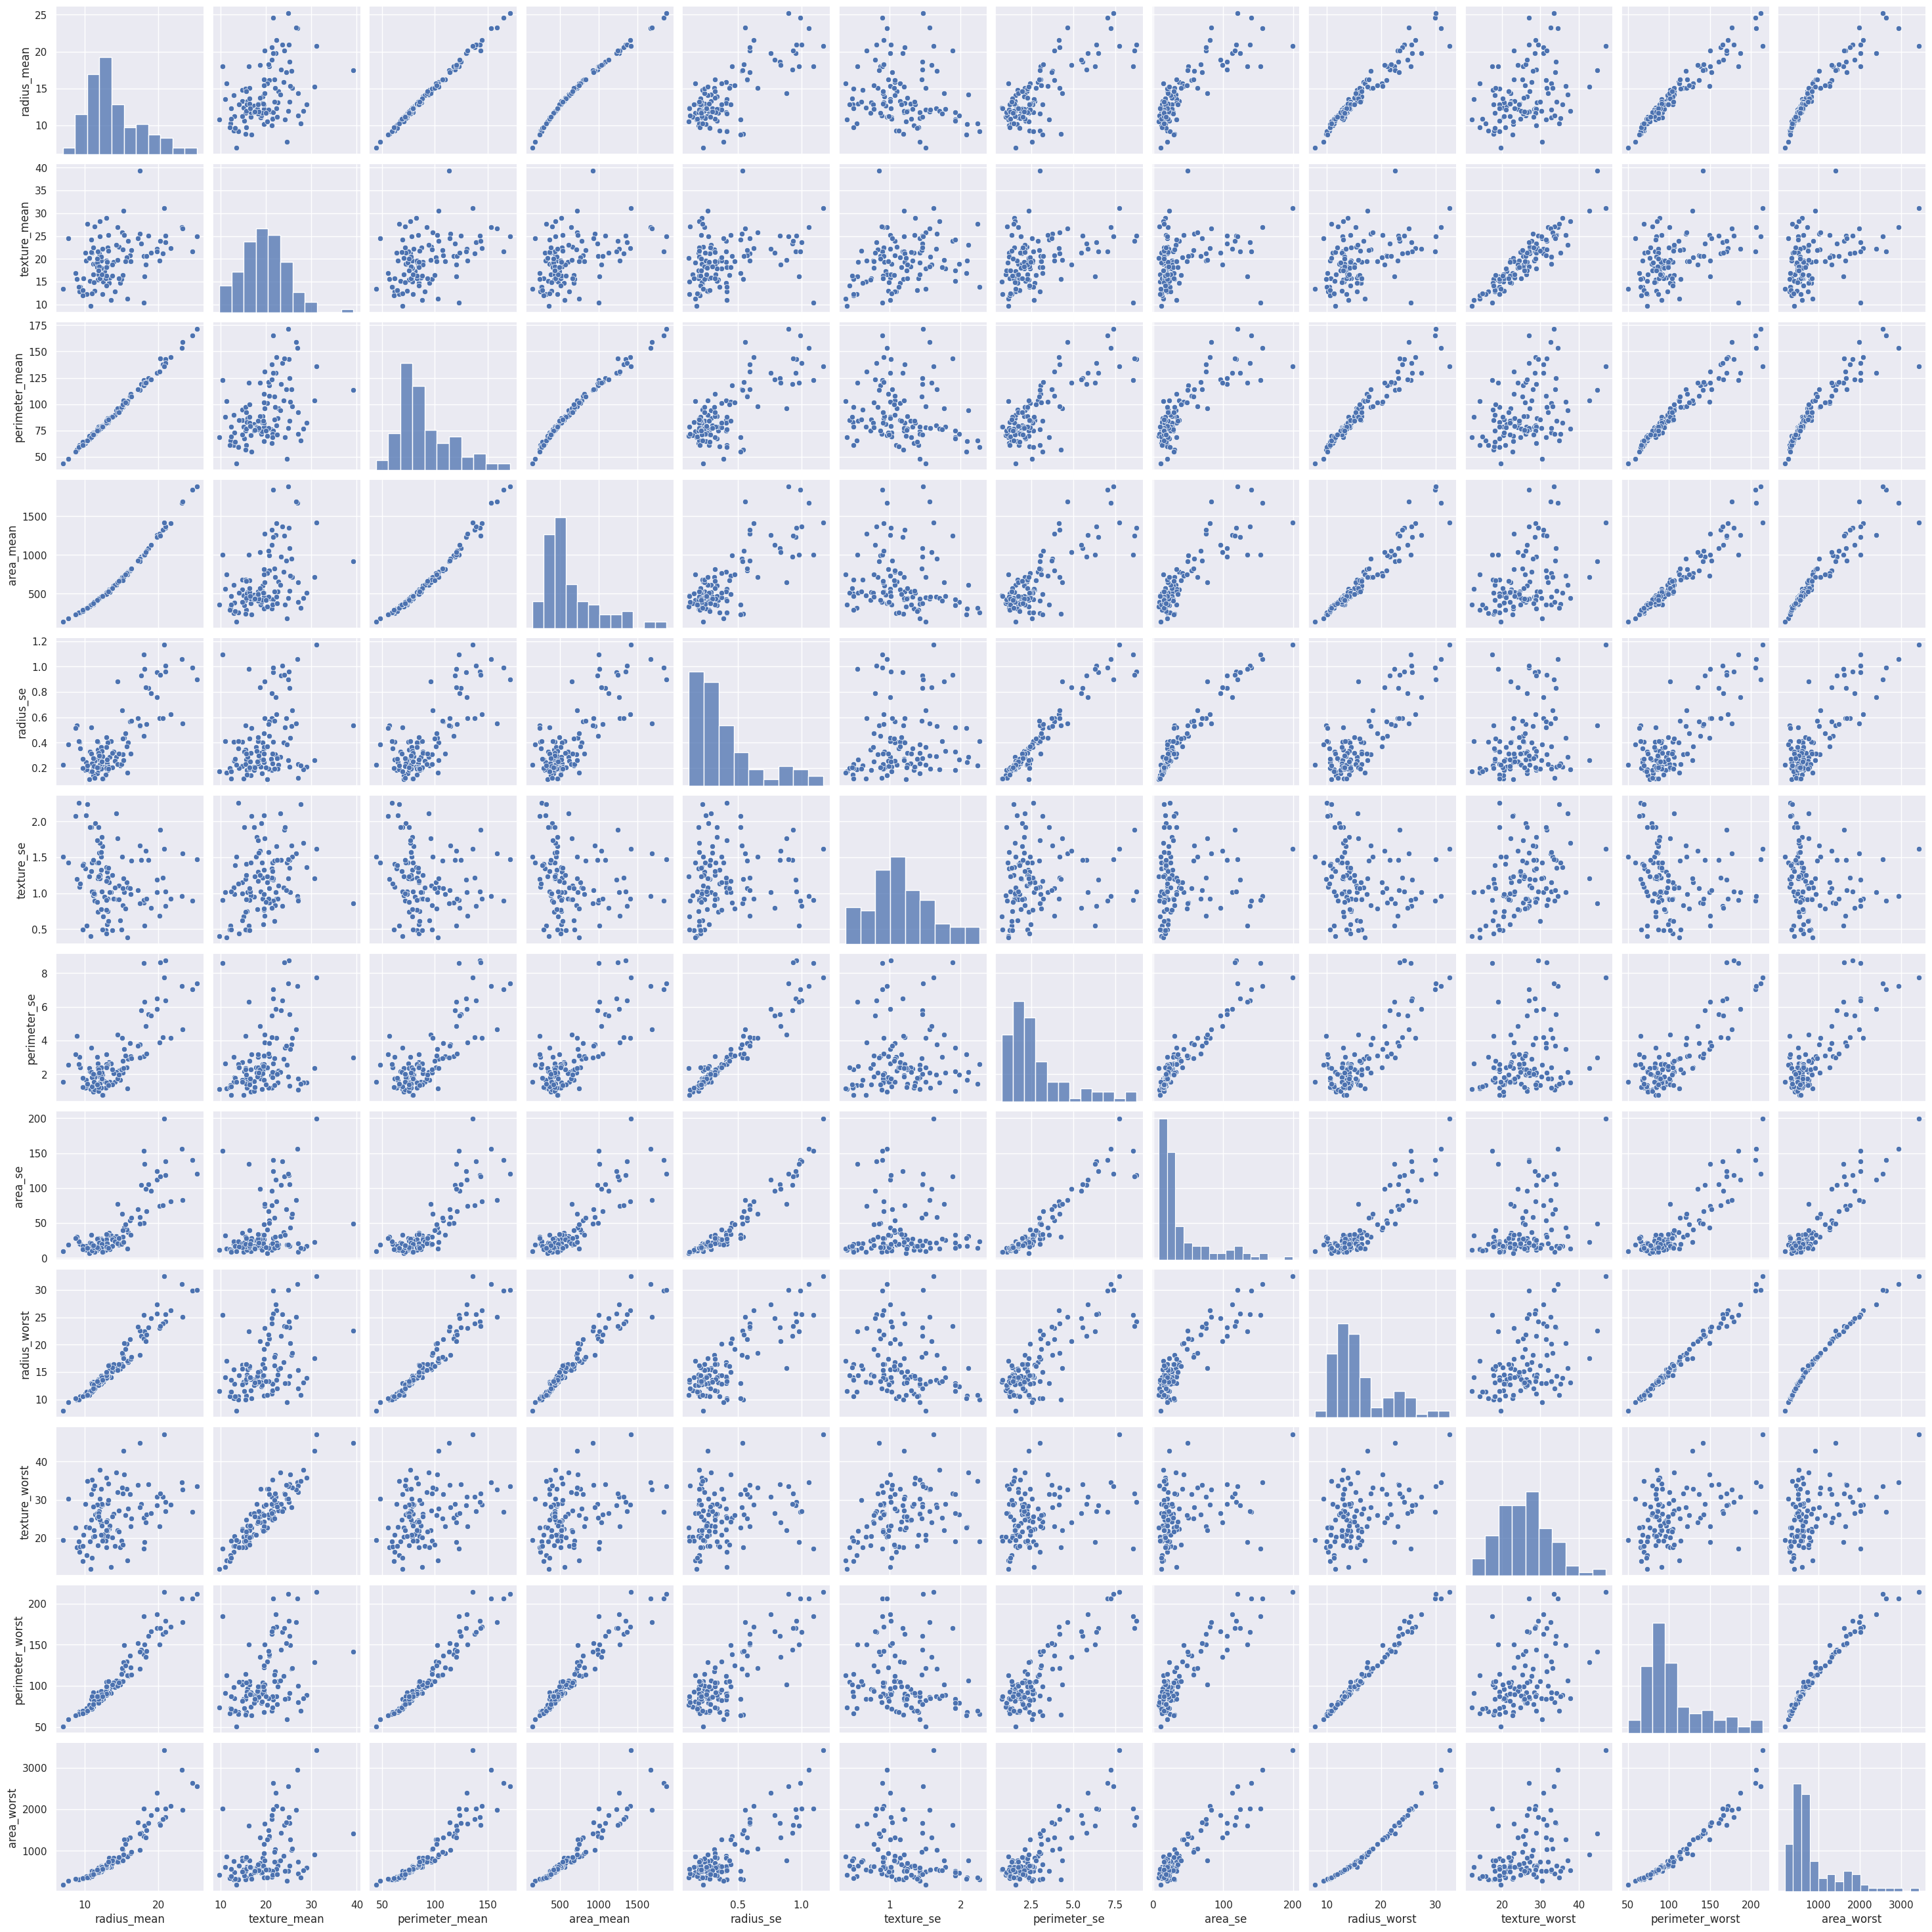

In [ ]:
# Sample 20% of the data
sample_df = pandas_df.sample(frac=0.2)

# Select only a subset of the features
selected_features = ['radius_mean', 'texture_mean', 'perimeter_mean','area_mean','radius_se','texture_se','perimeter_se','area_se','radius_worst',
                     'texture_worst','perimeter_worst','area_worst']

sns.pairplot(sample_df[selected_features])
plt.show()



As the dataset is large, it was taking me alot of time to compute
hence I chose some parameters.

Here I am randomly selecting 20% of the rows from the original pandas_df DataFrame.

I am then selecting subset of features from sample_df for plotting.
The selected_features list contains specific column names that are numerical and provide insights when visualized.

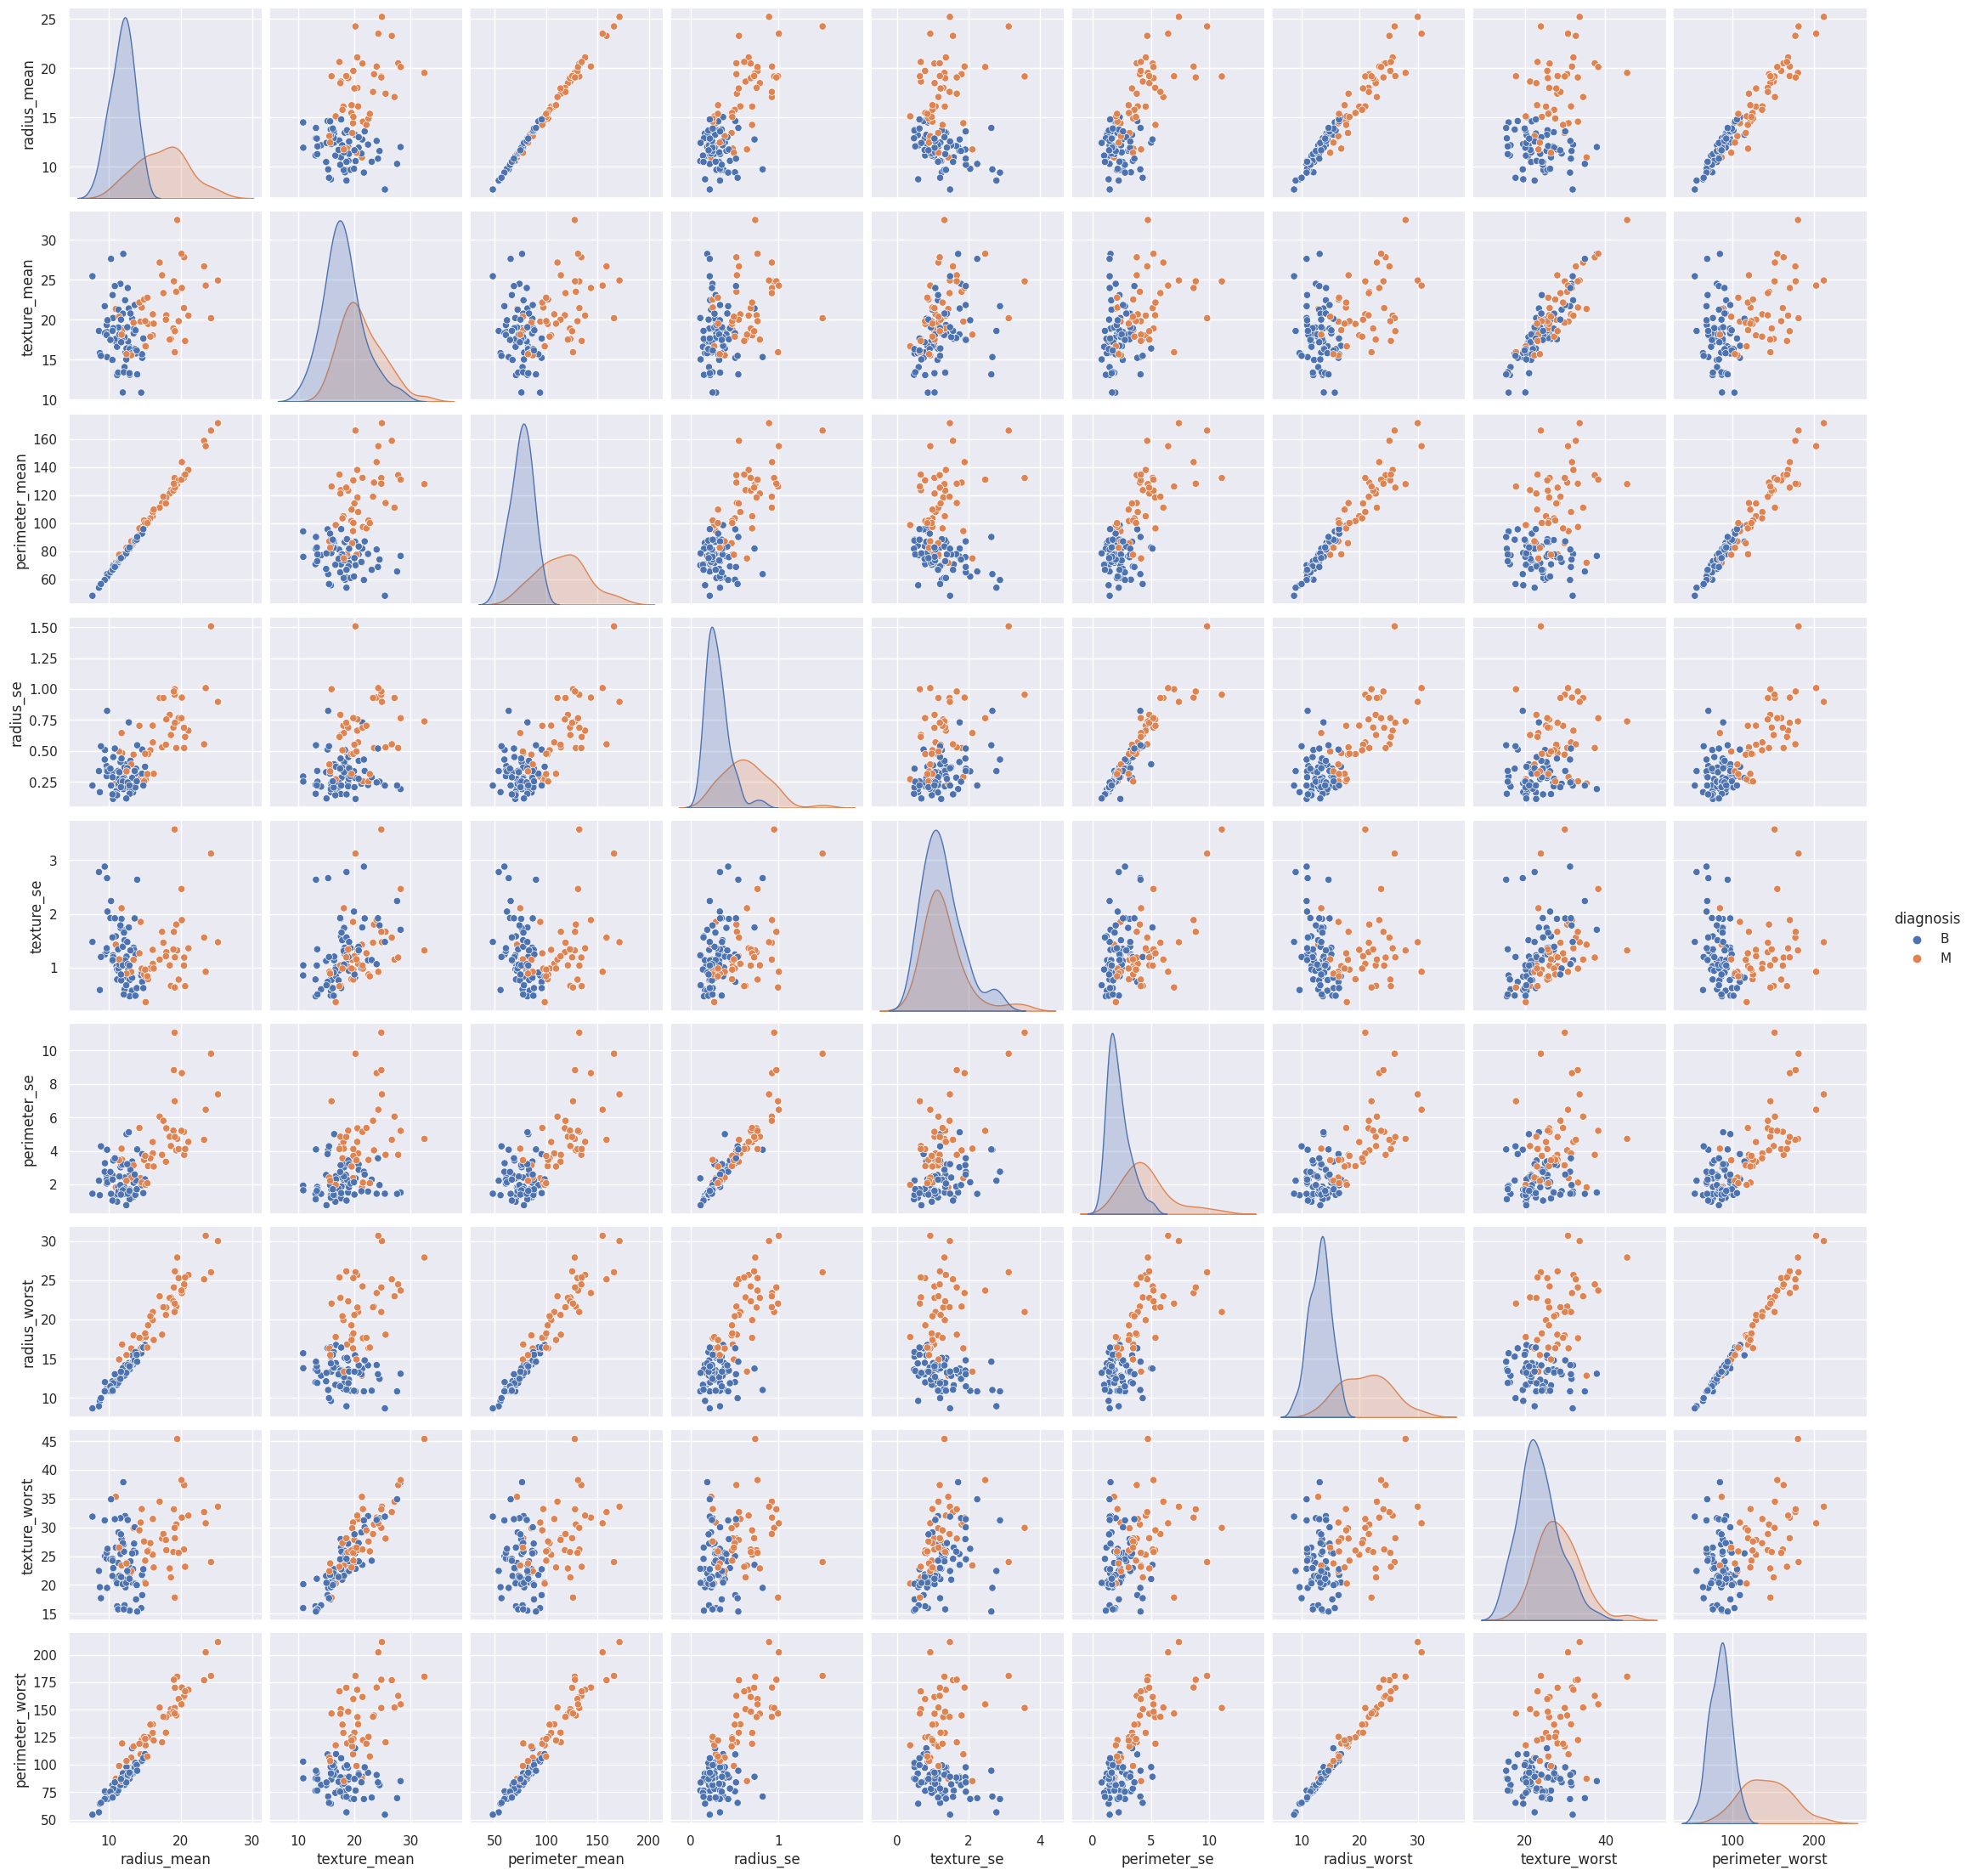

In [ ]:
# Sample 20% of the data
sample_df = pandas_df.sample(frac=0.2)

# Select only a subset of the features
selected_features = ['diagnosis','radius_mean', 'texture_mean', 'perimeter_mean','radius_se','texture_se','perimeter_se','radius_worst',
                     'texture_worst','perimeter_worst']

sns.pairplot(sample_df[selected_features], hue='diagnosis')
plt.show()



array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'perimeter_mean'}>,
        <Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'smoothness_mean'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'concave points_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>,
        <Axes: title={'center': 'fractal_dimension_mean'}>,
        <Axes: title={'center': 'radius_se'}>],
       [<Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'perimeter_se'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'smoothness_se'}>,
        <Axes: title={'center': 'compactness_se'}>,
        <Axes: title={'center': 'concavity_se'}>],
       [<Axes: title={'center': 'concave points_se'}>,
        <Axes: title={'center': 's

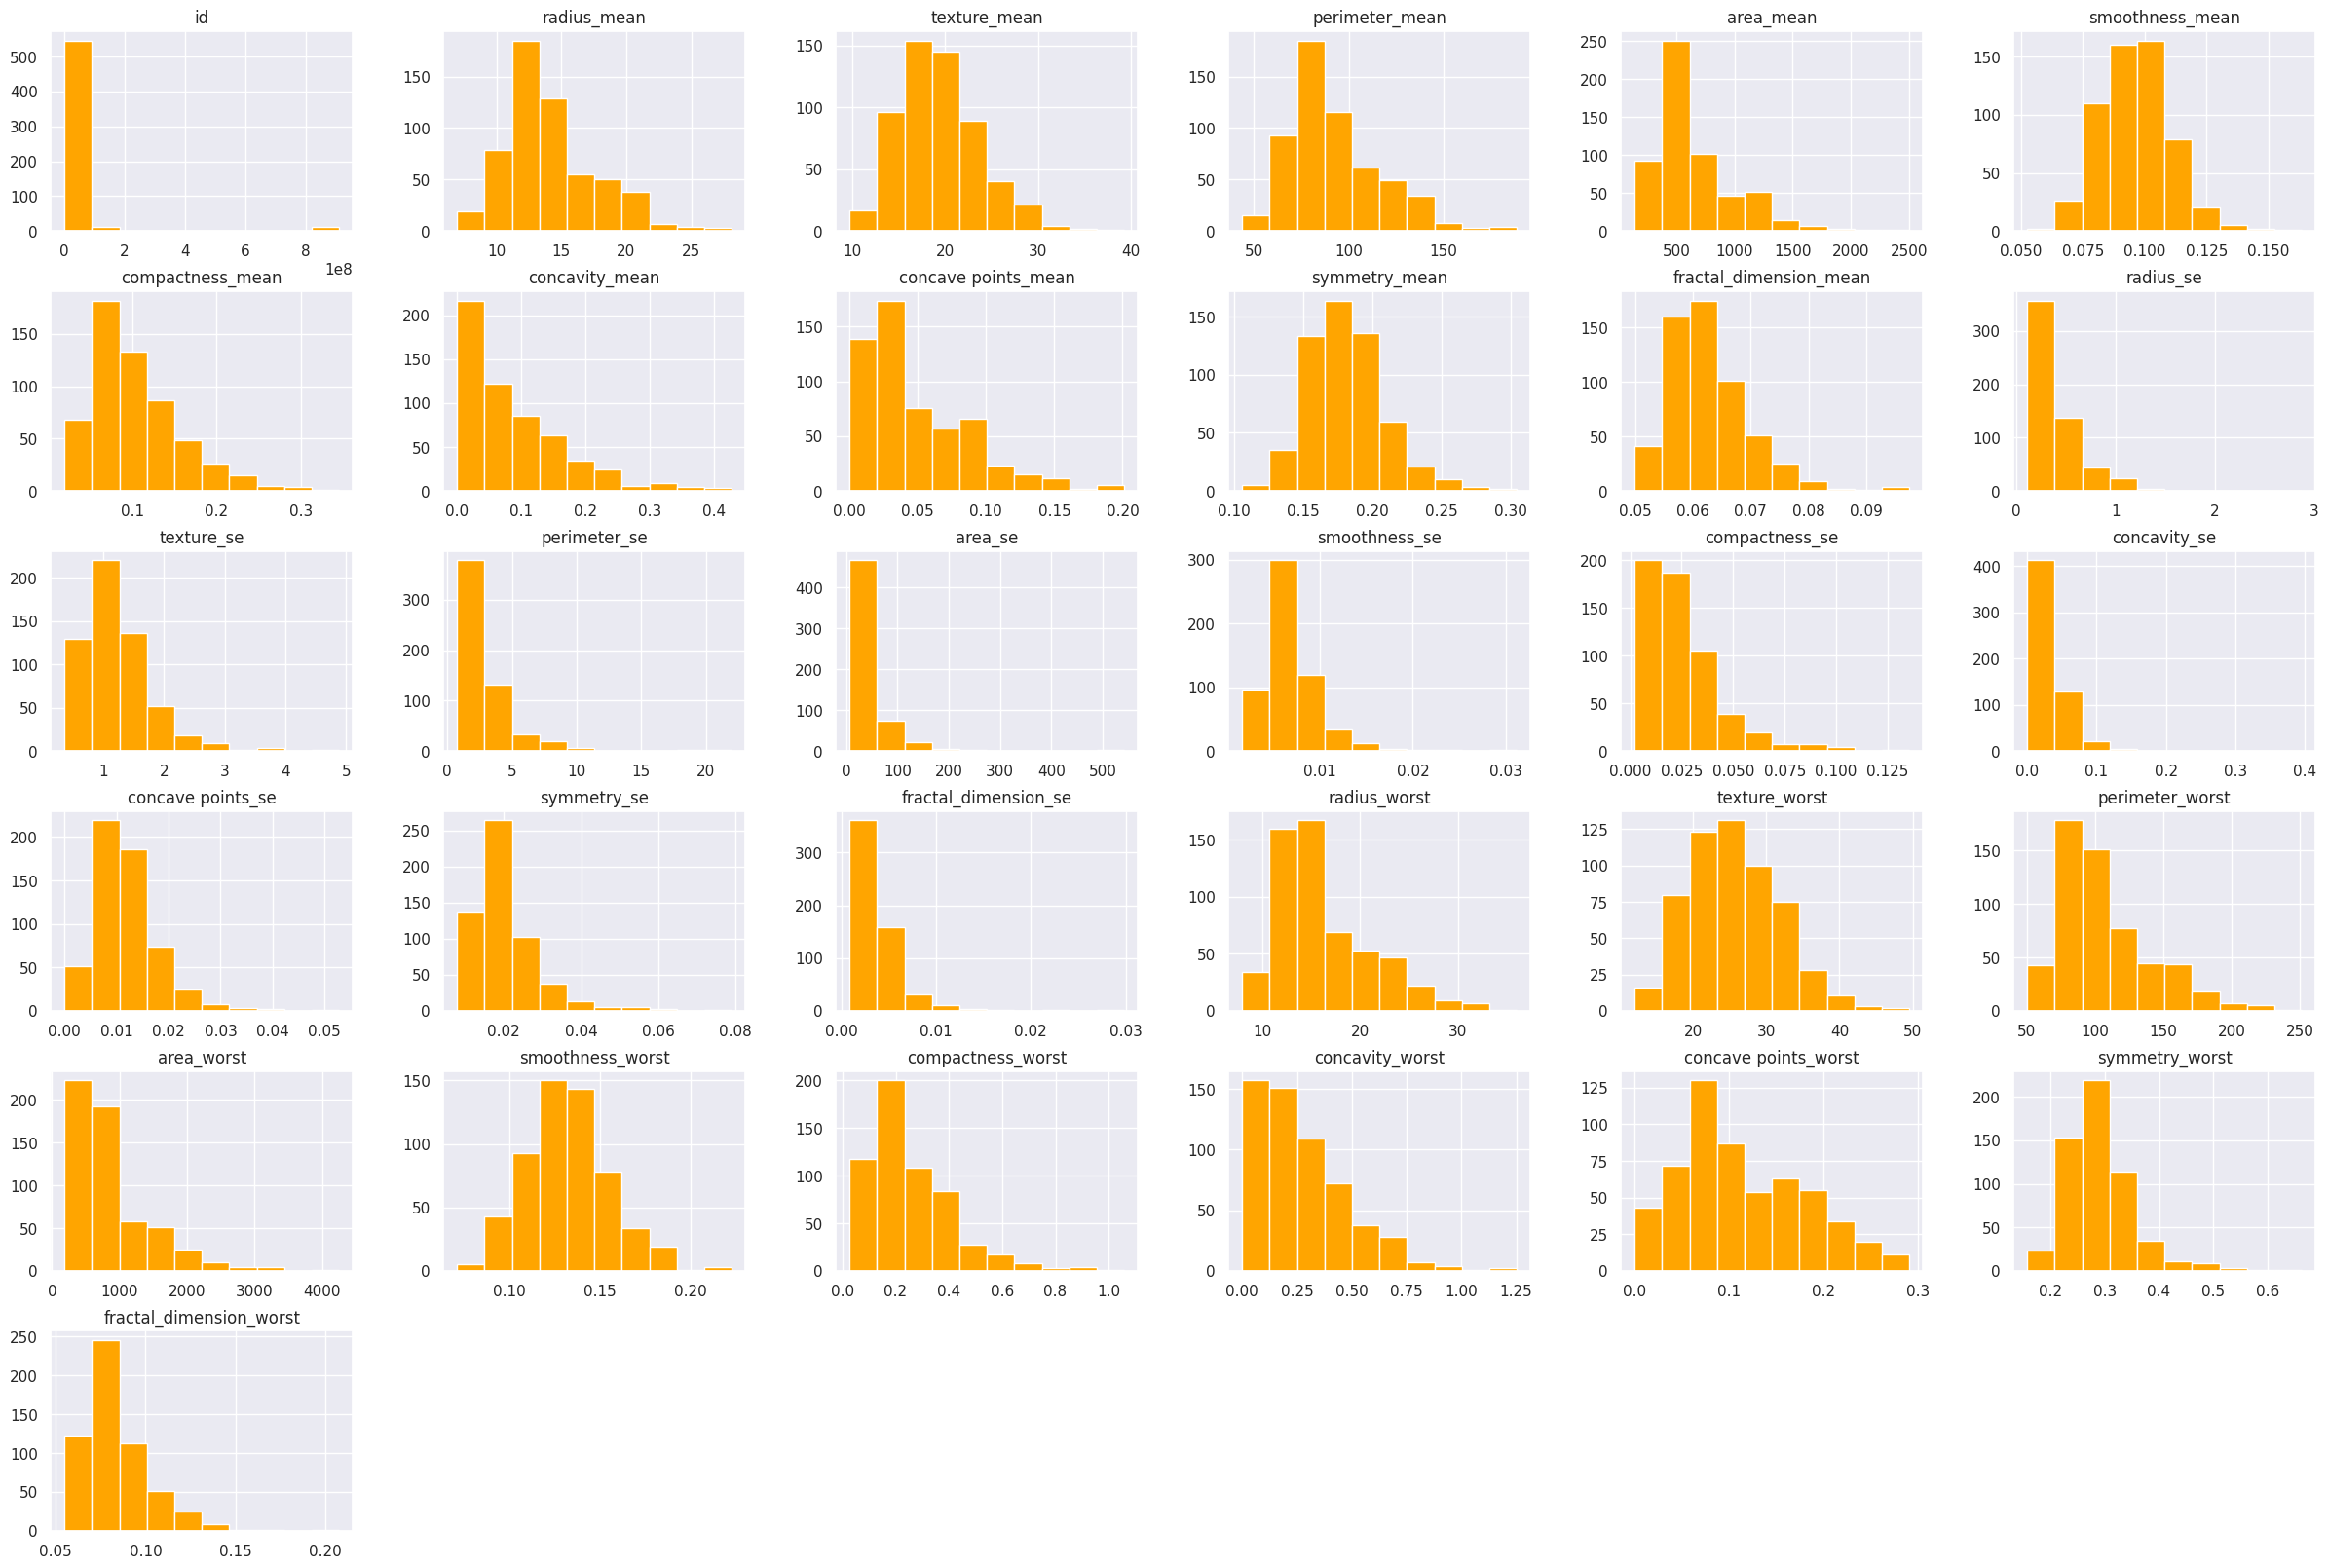

In [ ]:
# Plotted Histogram
pandas_df.hist(color="orange", figsize=(30, 20))

The purpose of plotting a histogram is to provide a visual representation of the underlying distribution of the data, which can help to identify patterns, outliers, and any other features of the data that may be of interest.

- **id:** Distribution predominantly leans towards **lower id** values.
- **radius_mean**: Most of the data lies between a radius_mean of **10 to 20**.
- **texture_mean:** Majority of observations have a texture_mean between 10 to 30.
- **perimeter_mean:** Common values for perimeter_mean range between **50 to 100.**
- **area_mean:** Predominant values for area_mean lie below **1000.**
- **smoothness_mean:** Most of the data points have a smoothness_mean value between **0.05 and 0.1.**
- c**ompactness_mean:** Majority of data falls between **0.05 and 0.1**5 in compactness_mean.
- **concavity_mean:** Data is mostly clustered between **0 and 0.3** for concavity_mean.
- **concave_points_mean:** Most values are **below 0.1** for concave_points_mean.
- symmetry_mean: Data predominantly lies between **0.1 and 0.25** for symmetry_mean.
- **fractal_dimension_mean:** Majority of values are concentrated between 0.05 and 0.075.
- **radius_se:** Data is primarily below 1 for radius_se.
- texture_se: Most observations for texture_se are under 2.
- **perimeter_se:** Values largely cluster below 5 for perimeter_se.
- **area_se:** Majority of area_se values lie under **200.**
- **smoothness_se:** Most of the data points fall below **0.0**1 in smoothness_se.
- **compactness_se:** Observations are predominantly under **0.05 for compactness_se.**
- **concavity_se:** Majority of the data is below **0.1** for concavity_se.
- **concave_points_se:** Observations majorly fall under 0.02 for concave_points_se.
- symmetry_se: Data is mostly concentrated between **0.01 and 0.03** for symmetry_se.
- **fractal_dimension_se:** Most values lie between **0.0 and 0.005.**
- **radius_worst:** Majority of the observations fall between **10 to 30** for radius_worst.
- **texture_worst:** Most texture_worst values lie between **10 to 40.**
- **perimeter_worst:** Common values range between 50 to 150 for perimeter_worst.
- **area_worst:** Observations are predominantly under 2000 for area_worst.
- **smoothness_worst:** Majority of the data falls between 0.1 and 0.15.
- c**ompactness_worst:** Compactness_worst values are primarily between 0.1 and 0.3.
- **concavity_worst:** Data is concentrated between **0 and 0.4** for concavity_worst.
- **concave_points_worst:** Most values are below **0.2** for concave_points_worst.
- **symmetry_worst:** Observations majorly lie between **0.2** and **0.4** for - symmetry_worst.
- **fractal_dimension_worst:** Majority of the data falls between **0.05 and 0.1.**



# **Identifing predictor significance**

In [ ]:
import statsmodels.api as sm

# Convert diagnosis column to numerical (M=1, B=0)
pandas_df['diagnosis'] = pandas_df['diagnosis'].map({'M': 1, 'B': 0})

# Define independent variables (features) and dependent variable (response)
X = pandas_df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']]
y = pandas_df['diagnosis']

# Add a constant to the model
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     205.9
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          1.40e-124
Time:                        04:54:31   Log-Likelihood:                -98.039
No. Observations:                 569   AIC:                             208.1
Df Residuals:                     563   BIC:                             234.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.4931      0.217    -

## **Is the relationship significant?**

1. **radius_mean** has a p-value of **0.843** which is greater than **0.05**, so it is not a significant feature.

2. **texture_mean** has a p-value of **0.000** which is lesser than **0.05**, so it is a significant feature.

3. **perimeter_mean** has a p-value of **0.005** which is lesser than **0.05**, so it is a significant feature.

4. **area_mean** has a p-value of **0.000** which is lesser than **0.05**, so it is a significant feature.

5. **smoothness_mean** has a p-value of **0.000** which is lesser than **0.05**, so it is a significant feature.

The relationship is significant when the p-value for the predictor variables is less than 0.05. If it is higher than 0.05, the result is non-significant. From the OLS method, the variables "texture_mean", "perimeter_mean", "area_mean", and "smoothness_mean" have p-values less than 0.05, indicating that they are statistically significant in the model. Any change in these variables has a significant impact on the target variable (diagnosis).

However, the variable **"radius_mean"** is not significant, indicating that, within the context of this model, changes in this variable might not significantly affect the diagnosis.

Therefore, for the breast cancer dataset that I chose, we can conclude that the relationship is significant for most of the features selected in the model, but not all.







## **VIF(multicollinearity)**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Indicate which variables to compute VIF for
# Note: From the dataset you've shared, I've chosen a subset of features for the VIF computation. Feel free to include or exclude features as you see fit.
features = pandas_df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']]

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)


         variables          VIF
0      radius_mean  3526.872924
1     texture_mean    22.329552
2   perimeter_mean  4527.360366
3        area_mean    89.413301
4  smoothness_mean    49.764471


**The Variance Inflation Factor (VIF) is a measure of how much the variance of the estimated regression coefficients increases if predictors are correlated.**

If no factors are correlated, the VIFs will all be equal to 1.

It signifies multicollinearity among set of different independent variable. A value greater than 10 means that the independent variable is highly correlated with some other variable. We have calculated VIF value for all variables to check the dependency.

- The VIF for '**area_mean**' and '**smoothness_mean**' is above the common threshold of 10, indicating moderate multicollinearity.

- The values are in the thousands for '**radius_mean**' and '**perimeter_mean**', which suggests that these variables are highly correlated with each other and possibly with other variables in the dataset.


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the columns if they exist in the DataFrame
cols_to_drop = [col for col in ['id', 'diagnosis'] if col in pandas_df.columns]
features = pandas_df.drop(columns=cols_to_drop)

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)



                  variables           VIF
0               radius_mean  63306.172036
1              texture_mean    251.047108
2            perimeter_mean  58123.586079
3                 area_mean   1287.262339
4           smoothness_mean    393.398166
5          compactness_mean    200.980354
6            concavity_mean    157.855046
7       concave points_mean    154.241268
8             symmetry_mean    184.426558
9    fractal_dimension_mean    629.679874
10                radius_se    236.665738
11               texture_se     24.675367
12             perimeter_se    211.396334
13                  area_se     72.466468
14            smoothness_se     26.170243
15           compactness_se     44.919651
16             concavity_se     33.244099
17        concave points_se     53.698656
18              symmetry_se     37.176452
19     fractal_dimension_se     27.532631
20             radius_worst   9674.742602
21            texture_worst    343.004387
22          perimeter_worst   4487

Created a new DataFrame (features) by dropping the specified columns from the original DataFrame (pandas_df).

I did this so I can focus on the VIF computation on actual features rather than identifiers or target variables.

- **Very High VIF (> 1000):** radius_mean, perimeter_mean, radius_worst, perimeter_worst have extremely high VIFs, suggesting that they are highly multicollinear with other variables in the data.

- **High VIF (100 - 1000):** area_mean, smoothness_mean, fractal_dimension_mean, area_worst, smoothness_worst, fractal_dimension_worst also show high multicollinearity. This indicates that they have strong linear relationships with other variables in the model.

- **Moderate VIF (10 - 100):** Most of the other variables fall into this category. They have moderate multicollinearity.

- **Low VIF (< 10):** texture_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se have low VIF meaning that they do not have serious multicollinearity with other variables.



In [ ]:
# Converted Pandas Dataframe to H2O dataframe to proceed with AutoML
df = h2o.H2OFrame(
    pandas_df
)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Datatype of all attributes

df.types

{'id': 'int',
 'diagnosis': 'int',
 'radius_mean': 'real',
 'texture_mean': 'real',
 'perimeter_mean': 'real',
 'area_mean': 'real',
 'smoothness_mean': 'real',
 'compactness_mean': 'real',
 'concavity_mean': 'real',
 'concave points_mean': 'real',
 'symmetry_mean': 'real',
 'fractal_dimension_mean': 'real',
 'radius_se': 'real',
 'texture_se': 'real',
 'perimeter_se': 'real',
 'area_se': 'real',
 'smoothness_se': 'real',
 'compactness_se': 'real',
 'concavity_se': 'real',
 'concave points_se': 'real',
 'symmetry_se': 'real',
 'fractal_dimension_se': 'real',
 'radius_worst': 'real',
 'texture_worst': 'real',
 'perimeter_worst': 'real',
 'area_worst': 'real',
 'smoothness_worst': 'real',
 'compactness_worst': 'real',
 'concavity_worst': 'real',
 'concave points_worst': 'real',
 'symmetry_worst': 'real',
 'fractal_dimension_worst': 'real'}

In [ ]:
# Setting up the data split between training and test dataset.

pct_rows = 0.80
df_train, df_test = df.split_frame([pct_rows])

In [ ]:
#Printing shapes

print(df_train.shape)
print(df_test.shape)

(453, 32)
(116, 32)


In [ ]:
#Displaying the first few rows of a dataframe

df_train.head()

id    diagnosis    radius_mean    texture_mean    perimeter_mean    area_mean    smoothness_mean    compactness_mean    concavity_mean    concave points_mean    symmetry_mean    fractal_dimension_mean    radius_se    texture_se    perimeter_se    area_se    smoothness_se    compactness_se    concavity_se    concave points_se    symmetry_se    fractal_dimension_se    radius_worst    texture_worst    perimeter_worst    area_worst    smoothness_worst    compactness_worst    concavity_worst    concave points_worst    symmetry_worst    fractal_dimension_worst
----------------  -----------  -------------  --------------  ----------------  -----------  -----------------  ------------------  ----------------  ---------------------  ---------------  ------------------------  -----------  ------------  --------------  ---------  ---------------  ----------------  --------------  -------------------  -------------  ----------------------  --------------  ---------------  -----------------  ------------  ------------------  -------------------  -----------------  ----------------------  ----------------  -------------------------
842302                      1          17.99           10.38            122.8        1001              0.1184              0.2776            0.3001                 0.1471            0.2419                   0.07871       1.095         0.9053           8.589     153.4          0.006399          0.04904          0.05373             0.01587         0.03003                0.006193           25.38            17.33             184.6         2019                0.1622               0.6656             0.7119                 0.2654             0.4601                    0.1189
842517                      1          20.57           17.77            132.9        1326              0.08474             0.07864           0.0869                 0.07017           0.1812                   0.05667       0.5435        0.7339           3.398      74.08         0.005225          0.01308          0.0186              0.0134          0.01389                0.003532           24.99            23.41             158.8         1956                0.1238               0.1866             0.2416                 0.186              0.275                     0.08902
     8.43009e+07            1          19.69           21.25            130          1203              0.1096              0.1599            0.1974                 0.1279            0.2069                   0.05999       0.7456        0.7869           4.585      94.03         0.00615           0.04006          0.03832             0.02058         0.0225                 0.004571           23.57            25.53             152.5         1709                0.1444               0.4245             0.4504                 0.243              0.3613                    0.08758
     8.43584e+07            1          20.29           14.34            135.1        1297              0.1003              0.1328            0.198                  0.1043            0.1809                   0.05883       0.7572        0.7813           5.438      94.44         0.01149           0.02461          0.05688             0.01885         0.01756                0.005115           22.54            16.67             152.2         1575                0.1374               0.205              0.4                    0.1625             0.2364                    0.07678
843786                      1          12.45           15.7              82.57        477.1            0.1278              0.17              0.1578                 0.08089           0.2087                   0.07613       0.3345        0.8902           2.217      27.19         0.00751           0.03345          0.03672             0.01137         0.02165                0.005082           15.47            23.75             103.4          741.6              0.1791               0.5249             0.5355                 0.1741             0.3985                  

In [ ]:
df_test.head()

id    diagnosis    radius_mean    texture_mean    perimeter_mean    area_mean    smoothness_mean    compactness_mean    concavity_mean    concave points_mean    symmetry_mean    fractal_dimension_mean    radius_se    texture_se    perimeter_se    area_se    smoothness_se    compactness_se    concavity_se    concave points_se    symmetry_se    fractal_dimension_se    radius_worst    texture_worst    perimeter_worst    area_worst    smoothness_worst    compactness_worst    concavity_worst    concave points_worst    symmetry_worst    fractal_dimension_worst
----------------  -----------  -------------  --------------  ----------------  -----------  -----------------  ------------------  ----------------  ---------------------  ---------------  ------------------------  -----------  ------------  --------------  ---------  ---------------  ----------------  --------------  -------------------  -------------  ----------------------  --------------  ---------------  -----------------  ------------  ------------------  -------------------  -----------------  ----------------------  ----------------  -------------------------
     8.43483e+07            1         11.42            20.38             77.58        386.1            0.1425              0.2839            0.2414                 0.1052            0.2597                   0.09744       0.4956        1.156            3.445      27.23         0.00911           0.07458          0.05661             0.01867         0.05963                0.009208           14.91            26.5               98.87         567.7              0.2098               0.8663            0.6869                  0.2575             0.6638                    0.173
844359                      1         18.25            19.98            119.6        1040              0.09463             0.109             0.1127                 0.074             0.1794                   0.05742       0.4467        0.7732           3.18       53.91         0.004314          0.01382          0.02254             0.01039         0.01369                0.002179           22.88            27.66             153.2         1606                0.1442               0.2576            0.3784                  0.1932             0.3063                    0.08368
     8.4862e+07             1         16.13            20.68            108.1         798.8            0.117               0.2022            0.1722                 0.1028            0.2164                   0.07356       0.5692        1.073            3.854      54.18         0.007026          0.02501          0.03188             0.01297         0.01689                0.004142           20.96            31.48             136.8         1315                0.1789               0.4233            0.4784                  0.2073             0.3706                    0.1142
849014                      1         19.81            22.15            130          1260              0.09831             0.1027            0.1479                 0.09498           0.1582                   0.05395       0.7582        1.017            5.865     112.4          0.006494          0.01893          0.03391             0.01521         0.01356                0.001997           27.32            30.88             186.8         2398                0.1512               0.315             0.5372                  0.2388             0.2768                    0.07615
     8.51082e+06            0          9.504           12.44             60.34        273.9            0.1024              0.06492           0.02956                0.02076           0.1815                   0.06905       0.2773        0.9768           1.909      15.7          0.009606          0.01432          0.01985             0.01421         0.02027                0.002968           10.23            15.66              65.13         314.9              0.1324               0.1148            0.08867                 0.06227            0.245                     

In [ ]:
X = df.columns
print(X)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [ ]:
# Set target and predictor variables
y = "diagnosis"
X.remove(y)  # Removing the result frm our predictors data
print(X)

['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


## Train AutoML Models

In [ ]:
# Setting of AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

Start the training by specifying:
training_frame: the dataframe that contains training data -- df_train in our
case

y: the column in the training_frame which contains the target variable -- diagnosis in our case

In [ ]:
# Trainig the dataset on different models
aml.train(x=X, y=y, training_frame=df_train)

AutoML progress: |
04:54:34.568: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
04:54:43.953: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
04:54:45.357: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
04:54:49.485: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
04:54:49.814: _response param, We have det

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20231102_45434


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  1/1
# GLM base models (used / total)           1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.006549909832895447
RMSE: 0.08093151322504384
MAE: 0.043570367739977425
RMSLE: 0.05776604911399819
Mean Residual Deviance: 0.006549909832895447
R^2: 0.9711628310041055
Null degrees of freedom: 452
Residual degrees of freedom: 448
Null deviance: 102.89183222958096
Residual deviance: 2.9671091543016375
AIC: -980.2633988327162

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.029447518950481495
RMSE: 0.1716027941220116
MAE: 0.09061505057298919
RMSLE: 0.12202989279305647
Mean Residual Deviance: 0.029447518950481495
R^2: 0.8703519434389754
Null degrees of freedom: 452
Residual degrees of freedom: 448
Null deviance: 103.53346764873905
Residual deviance: 13.339726084568117
AIC: -299.33265414103704

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.0902648  0.0154889  0.0703573     0.11152       0.0983306     0.0866055     0.0845108
mean_residual_deviance  0.0290028  0.0115385  0.0154908     0.0473223     0.0263771     0.0263158     0.029508
mse                     0.0290028  0.0115385  0.0154908     0.0473223     0.0263771     0.0263158     0.029508
null_deviance           20.7067    2.42632    22.0706       24.0697       18.0246       18.9448       20.4237
r2                      0.870356   0.0483865  0.935212      0.801083      0.863368      0.887152      0.864966
residual_deviance       2.66778    1.25083    1.40966       4.73223       2.32119       2.13158       2.74424
rmse                    0.167682   0.0332711  0.124462      0.217537      0.16241       0.162222      0.171779
rmsle                   0.119255   0.0253192  0.0803112     0.150801      0.126496      0.119222      0.119443

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# **H2O AutoML trains and cross validates the following models in the following order:**

- Three pre-specified XGBoost GBM (Gradient Boosting Machine) models
- A fixed grid of GLMs
- A default Random Forest (DRF)
- Five pre-specified H2O GBMs
- A near-default Deep Neural Net
- An Extremely Randomized Forest (XRT)
- A random grid of XGBoost GBMs
- A random grid of H2O GBMs
- A random grid of Deep Neural Nets

## **Interpretting the above training output:**

**The reported metrics are for the Gradient Boosting Machine model in H2O AutoML. The metrics are reported separately for the training data and the cross-validation data.**

Model Performance on Training Data:

1. **MSE (Mean Squared Error):** The MSE is approximately 0.00984, suggesting that, the squared difference between the predicted and actual values is quite small, indicating good model accuracy on the training data.
2. **RMSE (Root Mean Squared Error):** The RMSE is around 0.09919, which is considered when comparing the model's performance with other.
3. **MAE (Mean Absolute Error):** The MAE value is roughly 0.06435, which provides an average of the absolute errors between the predictions and actual values.
4. **RMSLE (Root Mean Squared Logarithmic Error):** The RMSLE of 0.06980 is relatively low, which means the model performs well on the magnitude of the errors when dealing with multiplicative (percentage) changes.
5. **Mean Residual Deviance:** Similar to MSE, it’s a measure of the goodness of fit of the model.
6.**R² (R-squared):** The high R² value of approximately 0.957 indicates that the model explains a large proportion of the variance in the outcome variable based on its inputs.









**Cross-Validation Metrics Summary:**

The cross-validation summary provides a more detailed look at the model’s performance across different folds:

- **MAE:** The mean MAE across folds is about 0.08687 with a standard deviation of 0.00908, indicating some variance in the model’s performance across different subsets of the data.

- **Mean Residual Deviance and MSE:** Both have the same values since they measure the same thing but are called differently in different contexts. The mean is approximately 0.02457, with some standard deviation across folds.

- **R²:** The average R² across folds is around 0.8936 with a relatively low standard deviation, suggesting that the model’s explanatory power is fairly consistent across different subsets.

- **RMSE and RMSLE:** Both show variability across the folds with their mean and standard deviation, with RMSE averaging around 0.15552 and RMSLE around 0.11142.

 **The increased error metrics in cross-validation compared to the training data performance indicate a potential overfitting.**


**Evaluation:**

After the models are trained, we can compare the model performance using the leaderboard. H2O AutoML produces a leaderboard which ranks the trained model based on a predefined metric. By default it ranks models by ascending order of logloss and rmse for classification and regression task respectively.

In [ ]:
# Leaderboard showing the performance of different models on the dataset.

lb=aml.leaderboard
lb.head(rows=lb.nrows)

model_id                                                    rmse        mse        mae     rmsle    mean_residual_deviance
------------------------------------------------------  --------  ---------  ---------  --------  ------------------------
StackedEnsemble_BestOfFamily_4_AutoML_1_20231102_45434  0.171603  0.0294475  0.0906151  0.12203                  0.0294475
GBM_grid_1_AutoML_1_20231102_45434_model_10             0.175164  0.0306824  0.0877122  0.123554                 0.0306824
StackedEnsemble_AllModels_2_AutoML_1_20231102_45434     0.179552  0.0322389  0.0925002  0.127501                 0.0322389
StackedEnsemble_BestOfFamily_3_AutoML_1_20231102_45434  0.179667  0.0322802  0.0937816  0.12804                  0.0322802
StackedEnsemble_BestOfFamily_2_AutoML_1_20231102_45434  0.180675  0.0326436  0.0937391  0.128223                 0.0326436
XGBoost_grid_1_AutoML_1_20231102_45434_model_13         0.180981  0.032754   0.0909761  0.129944                 0.032754
GBM_grid_1_AutoML_1_20231102_45434_model_1              0.181597  0.0329773  0.0939894  0.127935                 0.0329773
GBM_3_AutoML_1_20231102_45434                           0.181725  0.0330239  0.0859177  0.128874                 0.0330239
GBM_grid_1_AutoML_1_20231102_45434_model_3              0.181844  0.0330672  0.0948975  0.129792                 0.0330672
GBM_2_AutoML_1_20231102_45434                           0.182376  0.0332609  0.0867297  0.129176                 0.0332609
GBM_4_AutoML_1_20231102_45434                           0.182388  0.0332653  0.0860521  0.129231                 0.0332653
StackedEnsemble_AllModels_4_AutoML_1_20231102_45434     0.182561  0.0333287  0.115138   0.129753                 0.0333287
XGBoost_grid_1_AutoML_1_20231102_45434_model_2          0.183439  0.03365    0.088614   0.129739                 0.03365
GBM_grid_1_AutoML_1_20231102_45434_model_20             0.183499  0.0336718  0.104827   0.131312                 0.0336718
StackedEnsemble_AllModels_3_AutoML_1_20231102_45434     0.183587  0.0337044  0.115833   0.130331                 0.0337044
StackedEnsemble_AllModels_1_AutoML_1_20231102_45434     0.184353  0.0339861  0.0937551  0.13091                  0.0339861
XRT_1_AutoML_1_20231102_45434                           0.184507  0.0340427  0.078543   0.130509                 0.0340427
DRF_1_AutoML_1_20231102_45434                           0.184511  0.0340445  0.0776986  0.131891                 0.0340445
XGBoost_grid_1_AutoML_1_20231102_45434_model_16         0.185378  0.034365   0.0941752  0.13019                  0.034365
GBM_grid_1_AutoML_1_20231102_45434_model_15             0.185685  0.0344791  0.0927993  0.130483                 0.0344791
GBM_grid_1_AutoML_1_20231102_45434_model_5              0.187009  0.0349725  0.0913151  0.131141                 0.0349725
GBM_grid_1_AutoML_1_20231102_45434_model_9              0.187501  0.0351565  0.0915264  0.132236                 0.0351565
XGBoost_grid_1_AutoML_1_20231102_45434_model_18         0.187889  0.0353023  0.103263   0.13476                  0.0353023
GBM_grid_1_AutoML_1_20231102_45434_model_17             0.188291  0.0354534  0.0825298  0.133835                 0.0354534
XGBoost_grid_1_AutoML_1_20231102_45434_model_9          0.188659  0.0355924  0.107818   0.135589                 0.0355924
GBM_grid_1_AutoML_1_20231102_45434_model_22             0.189275  0.035825   0.0971304  0.134051                 0.035825
GBM_grid_1_AutoML_1_20231102_45434_model_2              0.189382  0.0358656  0.0849848  0.133754                 0.0358656
XGBoost_grid_1_AutoML_1_20231102_45434_model_1          0.190371  0.0362411  0.0960354  0.135741                 0.0362411
XGBoost_grid_1_AutoML_1_20231102_45434_model_15         0.190971  0.0364699  0.106911   0.136981                 0.0364699
GBM_grid_1_AutoML_1_20231102_45434_model_7              0.191258  0.0365798  0.0904262  0.135502                 0.0365798
GBM_grid_1_AutoML_1_20231102_45434_model_13             0.19131   0.0

By looking at the leaderboard, we can see that the best model is the Gradient Boosting Model with the best model from each family, meaning that this model was built using the best model of each of the trained algorithms.

In [ ]:
#printing the best model
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20231102_45434


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  1/1
# GLM base models (used / total)           1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.006549909832895447
RMSE: 0.08093151322504384
MAE: 0.043570367739977425
RMSLE: 0.0577660

## How did AutoML pick this model?


The model that was probably chosen as the best model because it has the lowest RMSE, which is a commonly used measure of the prediction error in regression problems.
However, it is important to evaluate the model based on other metrics and use cross-validation to get a more accurate estimate of the model's performance on unseen data.

In [ ]:
#assign index values to all the models generated
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

{'StackedEnsemble_BestOfFamily_4_AutoML_1_20231102_45434': 0,
 'GBM_grid_1_AutoML_1_20231102_45434_model_10': 1,
 'GLM_1_AutoML_1_20231102_45434': 64}

In [ ]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])

1


In [ ]:
best_model.algo

'gbm'

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

<ipython-input-36-a0f01d27643e>:8: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


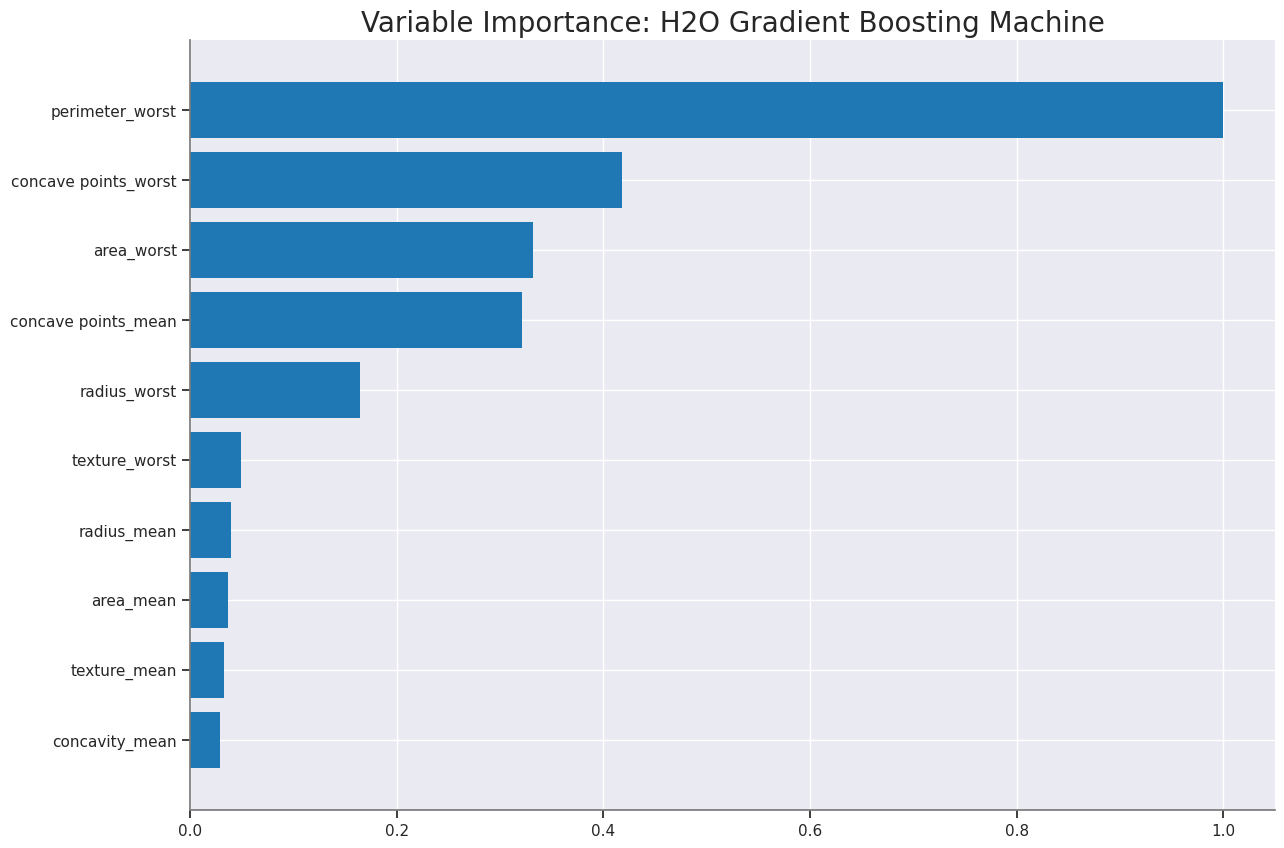

<Figure size 1600x800 with 0 Axes>

In [ ]:
# Importance of all the variables in GBM algorithm.
if best_model.algo in [
    "gbm",
    "drf",
    "xrt",
    "xgboost"
    "StackedEnsemble",
]:
    best_model.varimp_plot()

## **Observations:**

- The above graph is a variable Importance Graph on the H20's Distributed Gradient boosting Machine Model

- We can interpret that perimeter_worst is the Most Important Variable among all with importance of 1.0 (Think as if this Importance is scaled to 100%)

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-38-878b7dc4a148>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


64
glm


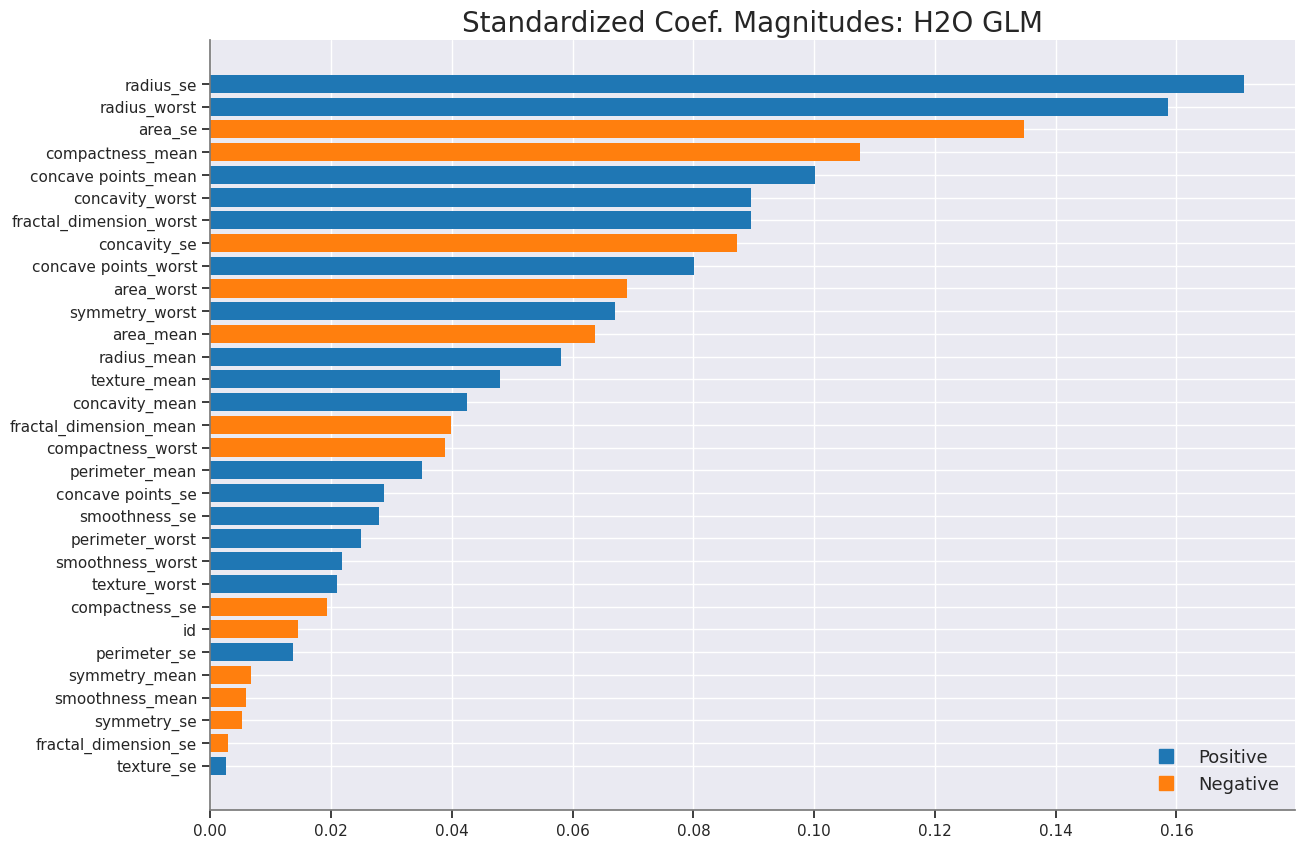

In [ ]:
#standardized coef Magnitudes for h20 GML
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

## **Analysis:**
**Standardized coefficient** magnitudes are a measure of the importance of each input variable in a predictive model, after standardizing all variables to have a mean of zero and a standard deviation of one.

The values of standardized coefficient magnitudes can range from negative infinity to positive infinity, but they are typically expressed as a percentage.

The values on standardized coefficient magnitudes represent the relative importance of each input variable in the model, after taking into account the scale of the variable. A higher magnitude value indicates that the variable has a stronger impact on the outcome variable, while a lower value indicates a weaker impact.

- **Feature Importance:** The bars indicate the importance or significance of each feature in the model. Longer bars imply a stronger influence on the model's output.
- **Positive vs. Negative Correlation:** Features with blue bars have a positive correlation with the response variable, meaning as the feature value increases, the likelihood of the event of interest. Conversely, features with orange bars show a negative correlation, implying that as these feature values go up, the likelihood of the event of interest decreases.
- **Top Features:** Some of the most influential features (based on bar length) are **radius_se, radius_worst, and area_se.**
- **Variety of Features:** The chart includes a diverse set of features such as texture, compactness, concavity, and smoothness, among others.
- **Coefficient Values:** The x-axis provides a measure of the standardized coefficients, which allows for a comparative understanding of each feature's magnitude in relation to the others.


In [ ]:
print(best_model.rmse(train=True))

0.0709721188767103


## Now, let's see how the best model performs on our test set.

In [ ]:
aml.leader.model_performance(test_data=df_test)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.024076329489552097
RMSE: 0.15516549065289
MAE: 0.07790605599126041
RMSLE: 0.10817486577218234
Mean Residual Deviance: 0.024076329489552097
R^2: 0.903234441573652
Null degrees of freedom: 115
Residual degrees of freedom: 111
Null deviance: 30.442709627745387
Residual deviance: 2.792854220788043
AIC: -91.08328789605208

In [ ]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Predictions on Test Dataset using the best model from the leaderboard.
y_pred = h2o.as_list(
    predictions
)
print(y_pred)


      predict
0    0.741650
1    1.003048
2    1.021512
3    1.046981
4   -0.000625
..        ...
111 -0.012564
112 -0.013883
113  0.017460
114  0.967152
115  0.943452

[116 rows x 1 columns]


##**Regularization**

In this Section, we will be using the GLM model to check if **regularization** is helping us to improve the accuracy and reduce overfitting.

- **Ridge** and **Lasso** are regularization techniques used in linear regression to prevent overfitting and improve the model's generalization ability.

- Ridge regularization adds a penalty term to the least-squares objective function of the linear regression model. This penalty term is proportional to the square of the magnitude of the coefficients of the model, which shrinks the coefficients towards zero. The strength of the penalty is controlled by a hyperparameter called the regularization parameter, which needs to be tuned to achieve the best performance. Ridge regularization is particularly useful when there are many input variables that are correlated with each other, as it can help to reduce the variance of the model by reducing the effect of these correlated variables.

- Lasso regularization is similar to Ridge regularization, but instead of adding a penalty term proportional to the square of the coefficients, it adds a penalty term proportional to the absolute value of the coefficients. This penalty term can set some coefficients to exactly zero, which makes Lasso regularization a useful method for feature selection. By setting some coefficients to zero, Lasso can effectively remove irrelevant variables from the model, which can lead to a simpler and more interpretable model.

- The main difference between Ridge and Lasso regularization is the type of penalty function used. Ridge uses L2 regularization, while Lasso uses L1 regularization. L2 regularization tends to distribute the penalty evenly across all coefficients, while L1 regularization tends to concentrate the penalty on a smaller subset of the most important coefficients.

**By adding regularization to a model, it can become less prone to overfitting and better at generalizing to new data.**

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
 # Elastic Net Regularization
disease_glm = H2OGeneralizedLinearEstimator(
    family="gaussian", lambda_=0, compute_p_values=True, nfolds=5
)
# RIDGE Regularization
disease_glm_regularization_ridge = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=0, nfolds=5
)
# LASSO Regularization
disease_glm_regularization_lasso = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=1, nfolds=5
)
# Lambda Search
disease_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)

In [ ]:
disease_glm.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698900740675_26


GLM Model: summary
    family    link      regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ----------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  None              31                            31                             1                       py_2_sid_bc16

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.05204834883154941
RMSE: 0.22814107221530586
MAE: 0.1779362983349945
RMSLE: 0.16792951047946297
Mean Residual Deviance: 0.05204834883154941
R^2: 0.7708476804253718
Null degrees of freedom: 452
Residual degrees of freedom: 421
Null deviance: 102.89183222958096
Residual deviance: 23.57790202069188
AIC: 12.679571239437642

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.06010999637741972
RMSE: 0.24517340063191953
MAE: 0.1908239190596818
RMSLE: 0.18249964029328786
Mean Residual Deviance: 0.06010999637741972
R^2: 0.7353548112719605
Null degrees of freedom: 452
Residual degrees of freedom: 421
Null deviance: 103.21482013521634
Residual deviance: 27.229828358971133
AIC: 77.9129687282293

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.191999   0.0128301   0.200271      0.184805      0.174542      0.19314       0.207238
mean_residual_deviance  0.0604763  0.00663077  0.0611753     0.0621069     0.0531779     0.0556426     0.0702789
mse                     0.0604763  0.00663077  0.0611753     0.0621069     0.0531779     0.0556426     0.0702789
null_deviance           20.643     2.90864     16.1589       21.4157       24.1749       21.3012       20.1642
r2                      0.731001   0.0324073   0.700241      0.727384      0.759587      0.768594      0.6992
residual_deviance       5.44597    0.620716    4.7105        5.83805       5.79639       4.84091       6.04398
rmse                    0.245628   0.0133755   0.247336      0.249213      0.230603      0.235887      0.265102
rmsle                   0.182546   0.0120132   0.188795      0.178732      0.180179      0.166417      0.198606

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse        training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  -------------------  -------------------  ------------------  ------------------
    2023-11-02 04:58:23  0.000 sec   0             102.89183222958096         0.22713428748251865
    2023-11-02 04:58:23  0.010 sec   1                                                             0.22814107221530586  0.05204834883154941  0.1779362983349945  0.7708476804253718

Variable Importances: 
variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
radius_worst          1.0478326082229614     1.0                   0.2348571021821083
radius_mean           0.7290611267089844     0.6957801475041061    0.16340890919865425
area_worst            0.5670313835144043     0.5411469151318389    0.12709219634265098
perimeter_mean        0.37460044026374817    0.3575002699133786    0.08396147742117765
area_mean             0.2614423930644989     0.24950778493893586   0.058598675342635166
perimeter_worst       0.21488752961158752    0.20507810877924407   0.048164050348880445
compactness_mean      0.16728273034095764    0.15964642541966267   0.037494096847794055
concavity_se     

## **Ridge Regularization**

In [ ]:
#training a generalized linear model (GLM) with Ridge regularization
disease_glm_regularization_ridge.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698900740675_27


GLM Model: summary
    family    link      regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Ridge ( lambda = 0.03723 )  31                            31                             1                       py_2_sid_bc16

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.054955368255472814
RMSE: 0.23442561347999671
MAE: 0.18318312866007905
RMSLE: 0.1700707379676337
Mean Residual Deviance: 0.054955368255472814
R^2: 0.7580489988342133
Null degrees of freedom: 452
Residual degrees of freedom: 421
Null deviance: 102.89183222958096
Residual deviance: 24.894781819729186
AIC: 37.29935010393898

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.0618686344737622
RMSE: 0.24873406375838875
MAE: 0.1938240340458008
RMSLE: 0.18093118526605262
Mean Residual Deviance: 0.0618686344737622
R^2: 0.7276120872832811
Null degrees of freedom: 452
Residual degrees of freedom: 421
Null deviance: 103.36812374862458
Residual deviance: 28.026491416614277
AIC: 90.9762120019501

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.19363    0.016305   0.192223      0.209385      0.187823      0.208633      0.170084
mean_residual_deviance  0.0618973  0.01048    0.0619532     0.0720412     0.0550268     0.072142      0.0483231
mse                     0.0618973  0.01048    0.0619532     0.0720412     0.0550268     0.072142      0.0483231
null_deviance           20.6736    3.84146    18.5705       23.9391       25.6667       17.7779       17.414
r2                      0.724336   0.0396973  0.72286       0.691811      0.770722      0.679318      0.756972
residual_deviance       5.6053     1.19179    5.14212       7.3482        5.77782       5.69922       4.05914
rmse                    0.248061   0.0213025  0.248904      0.268405      0.234578      0.268593      0.219825
rmsle                   0.180294   0.0149038  0.173625      0.189545      0.180294      0.198435      0.159573

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse        training_deviance     training_mae         training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  -------------------  --------------------  -------------------  ------------------
    2023-11-02 04:58:23  0.000 sec   0             102.89183222958096         0.22713428748251865
    2023-11-02 04:58:23  0.005 sec   1                                                             0.23442561347999671  0.054955368255472814  0.18318312866007905  0.7580489988342133

Variable Importances: 
variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
radius_se                0.12029307335615158    1.0                   0.08893133967122588
radius_worst             0.1039063110947609     0.863776343855856     0.07681678743541473
area_se                  0.09787191450595856    0.8136122203494567    0.0723556247285578
concave points_mean      0.0855255275964737     0.710976328148657     0.06322807733678917
concave points_worst     0.07985905557870865    0.6638707728604624    0.05903891719905303
compactness_mean         0.07659744471311569    0.6367569019234691    0.056627644332953496
concavity_worst          0.07392383366823196    0.61453

## **Lasso Regularization**

In [ ]:
#training a generalized linear model (GLM) with Lasso regularization
disease_glm_regularization_lasso.train(x=X, y=y, training_frame=df_train)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698900740675_28


GLM Model: summary
    family    link      regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Lasso (lambda = 0.03723 )  31                            7                              1                       py_2_sid_bc16

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.06691809926718681
RMSE: 0.2586853286662906
MAE: 0.20752224757083507
RMSLE: 0.1834392171110295
Mean Residual Deviance: 0.06691809926718681
R^2: 0.7053809003964785
Null degrees of freedom: 452
Residual degrees of freedom: 445
Null deviance: 102.89183222958096
Residual deviance: 30.313898968035627
AIC: 78.51684081709588

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.07067962658598682
RMSE: 0.2658564021910829
MAE: 0.2136391655524682
RMSLE: 0.18780155978189886
Mean Residual Deviance: 0.07067962658598682
R^2: 0.6888200924247206
Null degrees of freedom: 452
Residual degrees of freedom: 446
Null deviance: 103.08210794827028
Residual deviance: 32.01787084345203
AIC: 101.29045572055645

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.213595   0.014154    0.225172      0.193959      0.213189      0.228911      0.206742
mean_residual_deviance  0.0706643  0.00883491  0.0798557     0.0616778     0.0658866     0.0804907     0.0654109
mse                     0.0706643  0.00883491  0.0798557     0.0616778     0.0658866     0.0804907     0.0654109
null_deviance           20.6164    1.65989     19.056        20.557        19.8874       23.4176       20.1642
r2                      0.688754   0.0323331   0.665067      0.716154      0.696548      0.645968      0.720035
residual_deviance       6.40357    1.08498     6.3086        5.79771       5.99568       8.29054       5.62534
rmse                    0.265417   0.0165099   0.282588      0.24835       0.256684      0.283709      0.255756
rmsle                   0.18731    0.0112671   0.194715      0.174698      0.185111      0.20245       0.179575

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse       training_deviance    training_mae         training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  ------------------  -------------------  -------------------  ------------------
    2023-11-02 04:58:24  0.000 sec   0             102.89183222958096         0.22713428748251865
    2023-11-02 04:58:24  0.006 sec   1                                                             0.2586853286662906  0.06691809926718681  0.20752224757083507  0.7053809003964785

Variable Importances: 
variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
radius_worst             0.17056600749492645    1.0                   0.39707298674307034
concave points_worst     0.12914229929447174    0.7571397208105086    0.3006397303240431
texture_worst            0.05720147863030434    0.3353627107206916    0.13316347318811733
concave points_mean      0.03675844892859459    0.21550864365332573   0.08557266080437408
symmetry_worst           0.027415357530117035   0.16073166003450315   0.06382220031407196
smoothness_worst         0.007663937285542488   0.04493238364490917   0.01784143577536957
radius_se                0.0008107968606054783  0.00475

**7. Does Regularization Method Help?**

The Lasso regularization appears to have the same MSE, RMSE, MAE, and RMSLE values compared to the non-regularized and Ridge regularized models, indicating no improvement in performance.

- **The Mean Squared Error (MSE)** on training data is 0.06691809926718681, and on cross-validation data, it is slightly higher at 0.07067962658598682. This indicates a small increase in error when the model is evaluated on data it hasn't seen during training.

- **The Root Mean Squared Error (RMSE)** shows a similar trend, with training data at 0.2586853286662906 and cross-validation data at 0.2658564021910829. This increment in RMSE suggests a marginal decrease in model performance on cross-validation.

- **The Mean Absolute Error (MAE)** also increases from 0.20752224757083507 in the training set to 0.2136391655524682 in the cross-validation set, reflecting a slight decrease in prediction accuracy.

- **The Root Mean Squared Log Error (RMSLE)** is higher on the cross-validation set (0.18780155978189886) compared to the training set (0.1834392171110295), which implies that the model’s predictions are less precise when applied to new data.

- The **R-squared value (R^2)** decreased from 0.7053809003964785 for the training data to 0.6888200924247206 for the cross-validation data. This suggests that the model’s ability to explain the variance in the outcome variable is reduced when it encounters new data, indicating a slight overfit to the training set.

Here, we can observe that after applying the ridge regularization, there are barely or no improvements in the evaluation metrics on the train data and cross validation data, hence it can be concluded that regularization technique is not so helpful to avoid the overfitting of model

In [ ]:
lambda_search = disease_glm_regularization_lamba_search.train(
    x=X, y=y, training_frame=df_train
)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698900740675_29


GLM Model: summary
    family    link      regularization                                 lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.007445 )  nlambda = 100, lambda.max = 0.7445, lambda.min = 0.007445, lambda.1se = -1.0  31                            18                             100                     py_2_sid_bc16

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.055867853266571066
RMSE: 0.23636381547641988
MAE: 0.18418353527032189
RMSLE: 0.168602209569146
Mean Residual Deviance: 0.055867853266571066
R^2: 0.7540316176575889
Null degrees of freedom: 452
Residual degrees of freedom: 434
Null deviance: 102.89183222958096
Residual deviance: 25.308137529756692
AIC: 18.759249675784126

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train        alpha    iterations    training_rmse        training_deviance     training_mae         training_r2
---  -------------------  ----------  -----------  --------  ------------  --------------------  -------  ------------  -------------------  --------------------  -------------------  ------------------
     2023-11-02 04:58:24  0.000 sec   1            .74E0     1             0.22713428748251782   0.5
     2023-11-02 04:58:24  0.002 sec   2            .71E0     4             0.21591058594359472   0.5
     2023-11-02 04:58:24  0.003 sec   3            .68E0     4             0.2047431497790542    0.5
     2023-11-02 04:58:24  0.003 sec   4            .65E0     4             0.19439942272635413   0.5
     2023-11-02 04:58:24  0.005 sec   5            .62E0     4             0.18484191663209812   0.5
     2023-11-02 04:58:24  0.005 sec   6            .59E0     5             0.17589070407830806   0.5
     2023-11-02 04:58:24  0.008 sec   7            .56E0     5             0.16754380921783268   0.5
     2023-11-02 04:58:24  0.014 sec   8            .54E0     5             0.1598579192219149    0.5
     2023-11-02 04:58:24  0.016 sec   9            .51E0     5             0.15278315074919036   0.5
     2023-11-02 04:58:24  0.022 sec   10           .49E0     5             0.14627367354525586   0.5
---  ---                  ---         ---          ---       ---           ---                   ---      ---           ---                  ---                   ---                  ---
     2023-11-02 04:58:24  0.120 sec   91           .11E-1    18            0.05788824331547456   0.5
     2023-11-02 04:58:24  0.120 sec   92           .11E-1    18            0.057588250872746514  0.5
     2023-11-02 04:58:24  0.121 sec   93           .1E-1     18            0.05730918002546374   0.5
     2023-11-02 04:58:24  0.122 sec   94           .98E-2    18            0.057051437026626406  0.5
     2023-11-02 04:58:24  0.122 sec   95           .94E-2    18            0.0568158390263461    0.5
     2023-11-02 04:58:24  0.123 sec   96           .9E-2     18            0.05659685155975577   0.5
     2023-11-02 04:58:24  0.124 sec   97           .86E-2    18            0.05639444407475957   0.5
     2023-11-02 04:58:24  0.125 sec   98           .82E-2    19            0.056209487185469885  0.5
     2023-11-02 04:58:24  0.126 sec   99           .78E-2    19            0.05603210342665948   0.5
     2023-11-02 04:58:24  0.127 sec   100          .74E-2    19            0.055867853266571     0.5      100           0.23636381547641988  0.055867853266571066  0.1841835352703218

The function will search for the optimal value of lambda that minimizes the error in the model fit, and will return the results of this search in the object "lambda_search". This object can then be used to access the results of the search and select the optimal lambda value.

In [ ]:
#extracting the coeffecients table from GLM Model
coeff_table = disease_glm._model_json["output"]["coefficients_table"]

In [ ]:
# Z-Value and P-Value showing the significance of each attributes.
coeff_table.as_data_frame()

names  coefficients     std_error   z_value   p_value  \
0                 Intercept -1.679023e+00  4.776847e-01 -3.514919  0.000488   
1                        id -7.982597e-11  8.801369e-11 -0.906972  0.364940   
2               radius_mean -2.137522e-01  2.024372e-01 -1.055894  0.291622   
3              texture_mean  1.607582e-02  9.066022e-03  1.773195  0.076919   
4            perimeter_mean  1.592326e-02  2.903049e-02  0.548501  0.583638   
5                 area_mean  7.729735e-04  6.755188e-04  1.144266  0.253163   
6           smoothness_mean  3.577187e-01  2.365165e+00  0.151245  0.879855   
7          compactness_mean -3.269899e+00  1.496235e+00 -2.185419  0.029409   
8            concavity_mean  1.093579e+00  1.222819e+00  0.894310  0.371667   
9       concave points_mean  2.455677e+00  2.277846e+00  1.078070  0.281620   
10            symmetry_mean -1.725864e-01  8.333948e-01 -0.207088  0.836041   
11   fractal_dimension_mean -2.745314e+00  6.336328e+00 -0.433266  0.665044   
12                radius_se  3.903740e-01  3.370980e-01  1.158043  0.247503   
13               texture_se  2.106985e-02  3.969070e-02  0.530851  0.595802   
14             perimeter_se  5.542288e-03  4.474642e-02  0.123860  0.901485   
15                  area_se -1.879502e-03  1.550476e-03 -1.212210  0.226112   
16            smoothness_se  1.210403e+01  8.159429e+00  1.483441  0.138706   
17           compactness_se  5.067521e-01  2.348877e+00  0.215742  0.829293   
18             concavity_se -3.725038e+00  1.417727e+00 -2.627472  0.008916   
19        concave points_se  7.967485e+00  6.086652e+00  1.309009  0.191245   
20              symmetry_se -9.647264e-01  3.088360e+00 -0.312375  0.754910   
21     fractal_dimension_se -6.257569e+00  1.254149e+01 -0.498950  0.618076   
22             radius_worst  2.263284e-01  6.926826e-02  3.267418  0.001174   
23            texture_worst -1.695100e-03  7.787452e-03 -0.217671  0.827791   
24          perimeter_worst -6.665916e-03  6.561262e-03 -1.015950  0.310237   
25               area_worst -1.058567e-03  4.186109e-04 -2.528760  0.011811   
26         smoothness_worst  1.513463e-01  1.693584e+00  0.089364  0.928835   
27        compactness_worst -2.168949e-01  4.424300e-01 -0.490235  0.624223   
28          concavity_worst  4.596010e-01  3.040860e-01  1.511417  0.131432   
29     concave points_worst  8.745611e-01  1.019233e+00  0.858058  0.391349   
30           symmetry_worst  1.107074e+00  5.770270e-01  1.918582  0.055713   
31  fractal_dimension_worst  5.110638e+00  2.673147e+00  1.911843  0.056575   

    standardized_coefficients  
0                    0.348786  
1                   -0.010632  
2                   -0.729061  
3                    0.068519  
4                    0.374600  
5                    0.261442  
6                    0.005016  
7                   -0.167283  
8                    0.085267  
9                    0.092621  
10                  -0.004775  
11                  -0.019431  
12                   0.110092  
13                   0.012031  
14                   0.011426  
15                  -0.087397  
16                   0.035413  
17                   0.009277  
18                  -0.117801  
19                   0.048781  
20                  -0.008221  
21                  -0.017403  
22                   1.047833  
23                  -0.010408  
24                  -0.214888  
25                  -0.567031  
26                   0.003397  
27                  -0.033262  
28                   0.094548  
29                   0.055528  
30                   0.066640  
31                   0.091549

**Explainability**

H2O AutoML also provides insights into model’s global explainability such as variable importance, partial dependence plot, SHAP values and model correlation with just one line of code.



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                    rmse        mse        mae      rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_1_20231102_45434_model_12             0.140285  0.01968    0.055284   0.0982556                 0.01968                   510                   0.017112  GBM
GBM_grid_1_AutoML_1_20231102_45434_model_9              0.146594  0.0214899  0.0658827  0.0977549                 0.0214899                 255                   0.021177  GBM
GBM_grid_1_AutoML_1_20231102_45434_model_21             0.147125  0.0216456  0.0597473  0.101443                  0.0216456                 394                   0.023454  GBM
XGBoost_grid_1_AutoML_1_20231102_45434_model_16         0.148648  0.0220962  0.0767461  0.102493                  0.0220962                 342                   0.021825  XGBoost
GBM_grid_1_AutoML_1_20231102_45434_model_2              0.151978  0.0230974  0.0630613  0.106736                  0.0230974                 438                   0.014543  GBM
GBM_grid_1_AutoML_1_20231102_45434_model_22             0.154414  0.0238436  0.0721831  0.104691                  0.0238436                 164                   0.018094  GBM
GBM_grid_1_AutoML_1_20231102_45434_model_5              0.154677  0.0239249  0.0726996  0.105914                  0.0239249                 820                   0.022974  GBM
GBM_grid_1_AutoML_1_20231102_45434_model_15             0.154761  0.023951   0.0657143  0.10814                   0.023951                  347                   0.027255  GBM
StackedEnsemble_BestOfFamily_3_AutoML_1_20231102_45434  0.155086  0.0240518  0.0771777  0.108076                  0.0240518                 358                   0.160854  StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20231102_45434  0.155165  0.0240763  0.0779061  0.108175                  0.0240763                 130                   0.047456  StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20231102_45434     0.156058  0.0243541  0.0768014  0.107648                  0.0243541                 306                   0.130152  StackedEnsemble
XGBoost_grid_1_AutoML_1_20231102_45434_model_2          0.15641   0.0244642  0.072759   0.10838                   0.0244642                1824                   0.010045  XGBoost
XGBoost_grid_1_AutoML_1_20231102_45434_model_14         0.158436  0.025102   0.0934121  0.114034                  0.025102                  478                   0.008204  XGBoost
GBM_2_AutoML_1_20231102_45434                           0.158486  0.0251179  0.0700309  0.106311                  0.0251179                 623                   0.023299  GBM
StackedEnsemble_AllModels_4_AutoML_1_20231102_45434     0.159126  0.0253211  0.0944737  0.11139                   0.0253211                 393                   0.750966  StackedEnsemble
XGBoost_grid_1_AutoML_1_20231102_45434_model_15         0.159133  0.0253233  0.0848221  0.108144                  0.0253233                 415                   0.010913  XGBoost
StackedEnsemble_AllModels_3_AutoML_1_20231102_45434     0.159467  0.0254296  0.0926448  0.110019                  0.0254296                 365                   0.555995  StackedEnsemble
GBM_grid_1_AutoML_1_20231102_45434_model_17             0.159857  0.0255541  0.0634644  0.113619                  0.0255541                 226                   0.02496   GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20231102_45434  0.160825  0.0258647  0.0824351  0.111647                  0.0258647                 241                   0.058384  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20231102_45434     0.160891  0.025886   0.0807132  0.11012                   0.025886                  251                   0.133487  StackedEnsemble
[20 rows x 9 co

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

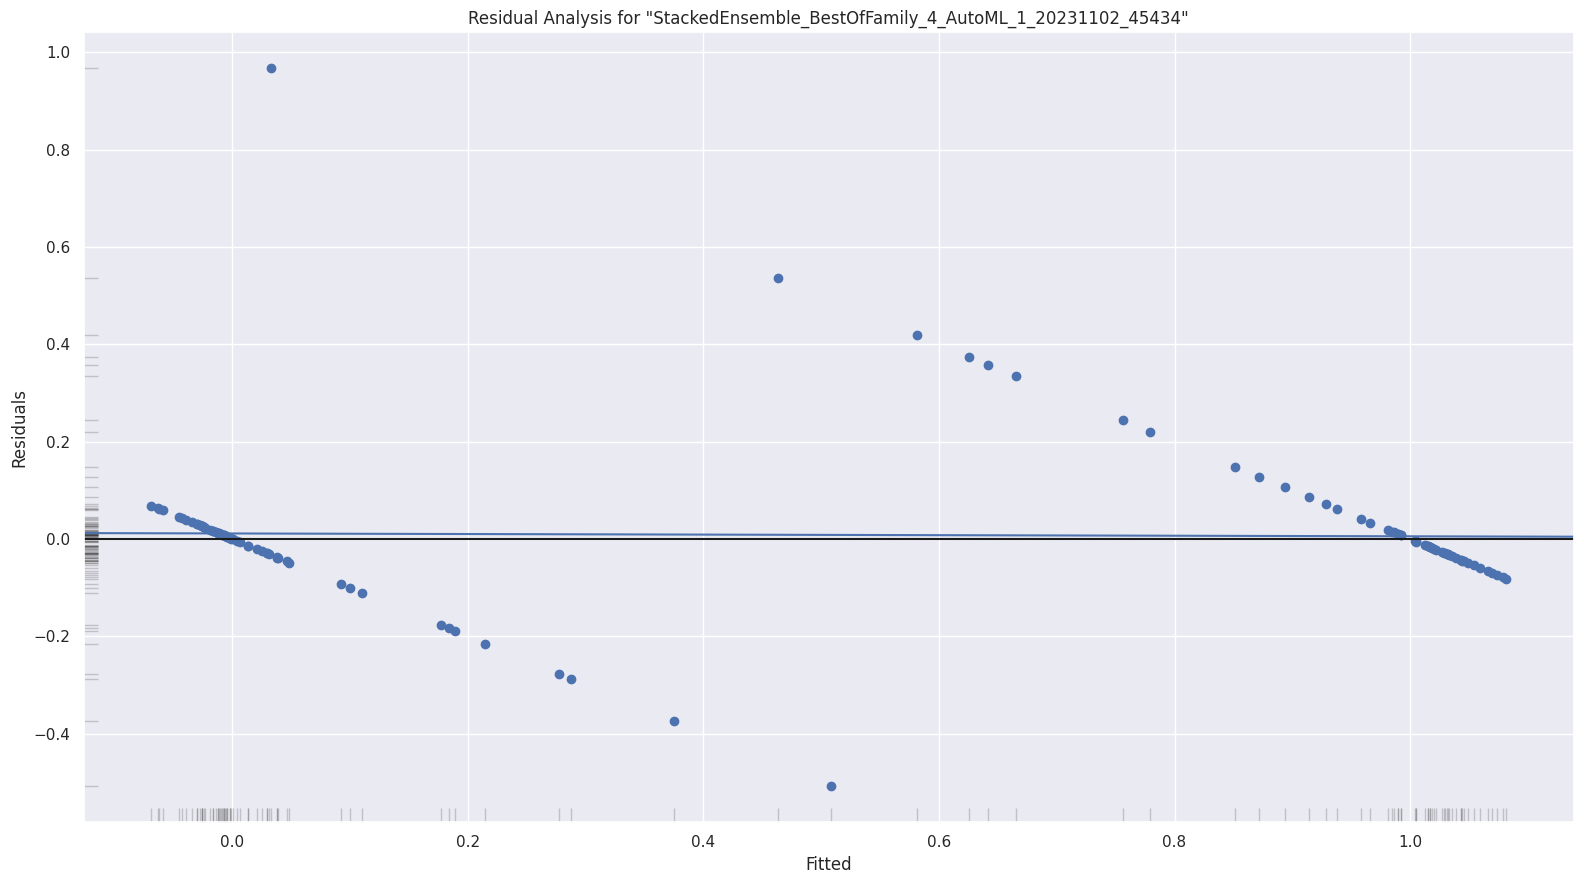

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

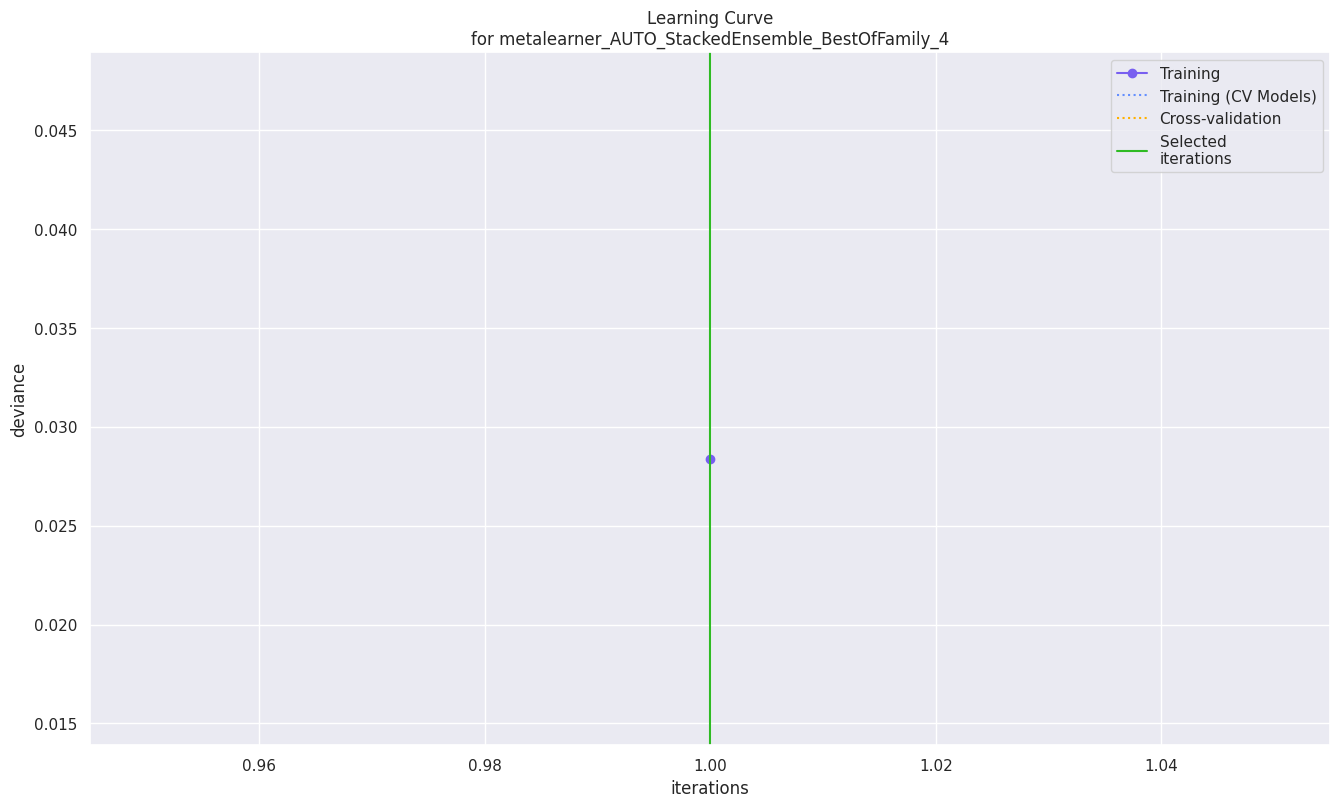

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

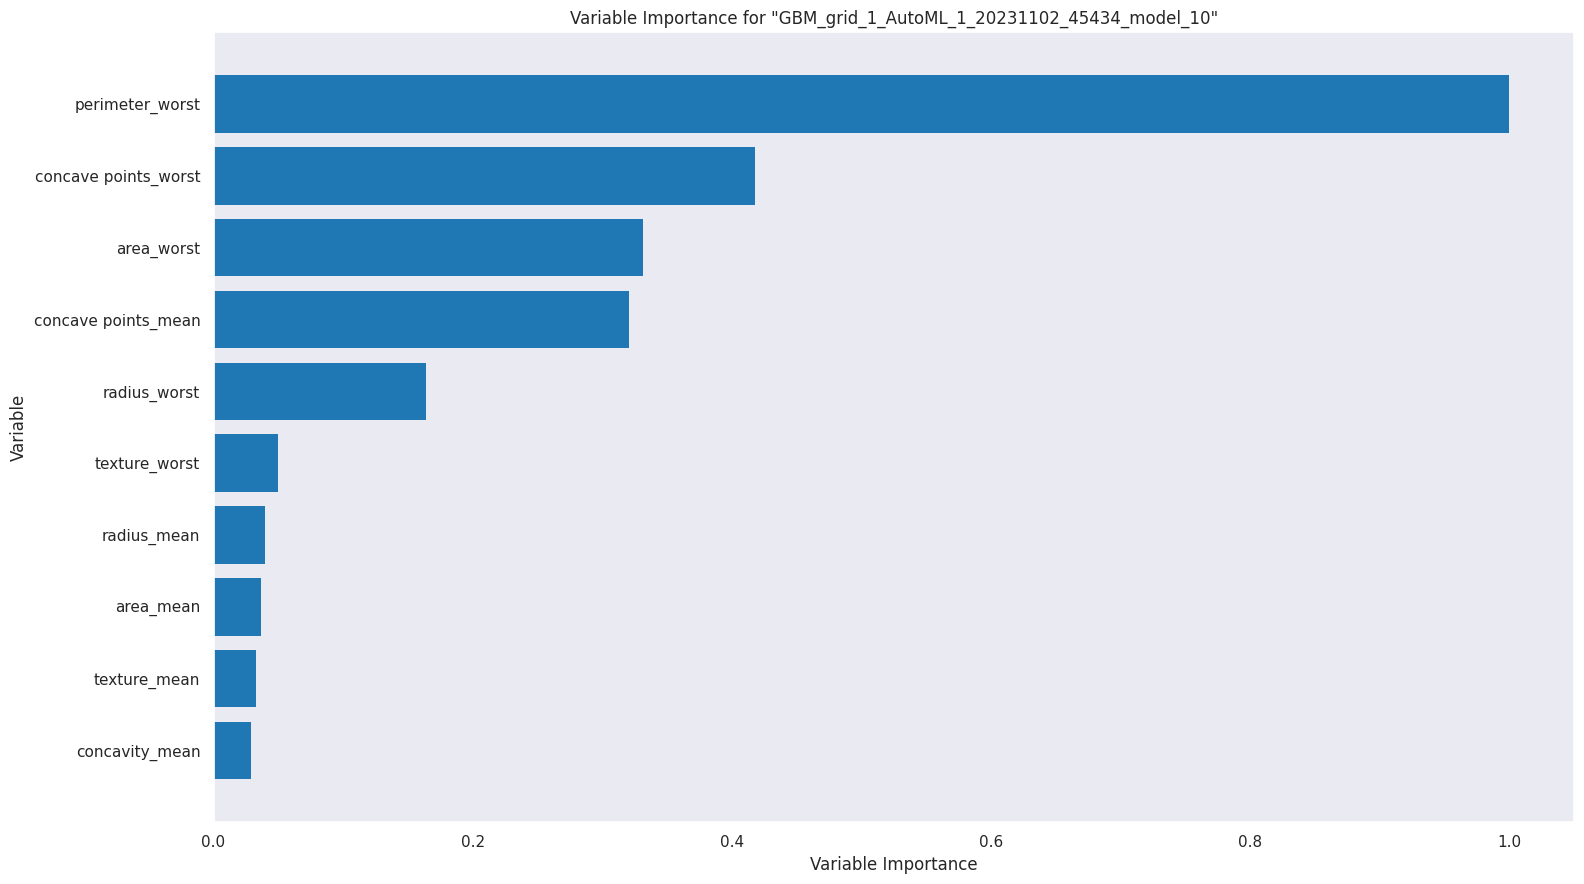

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

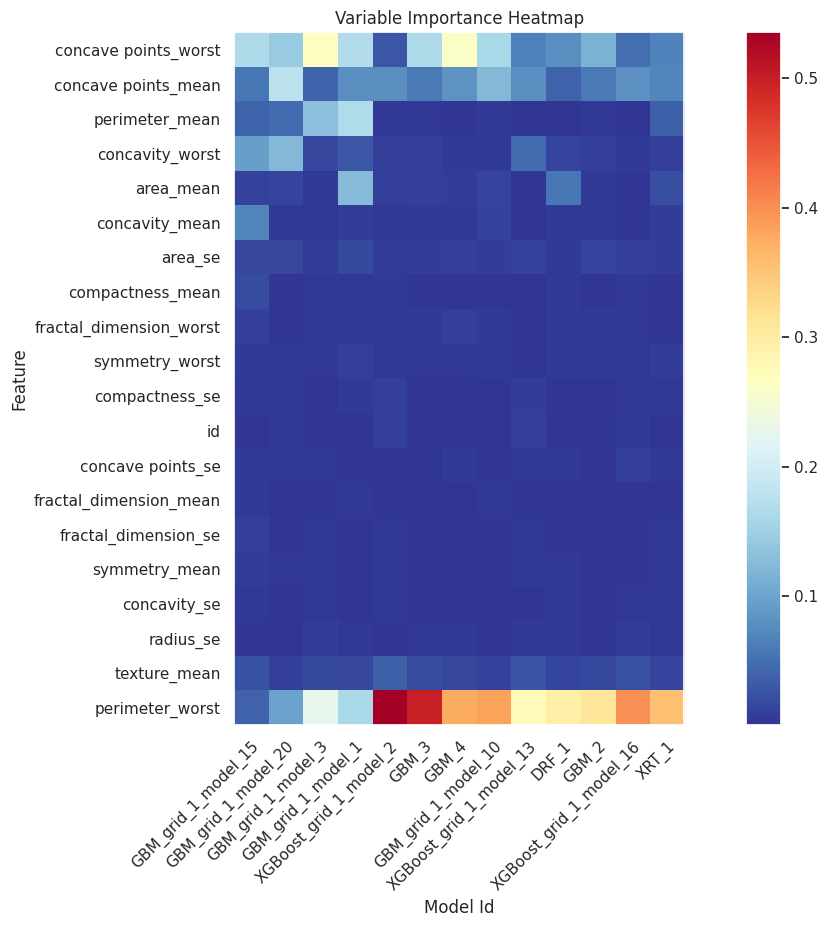

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

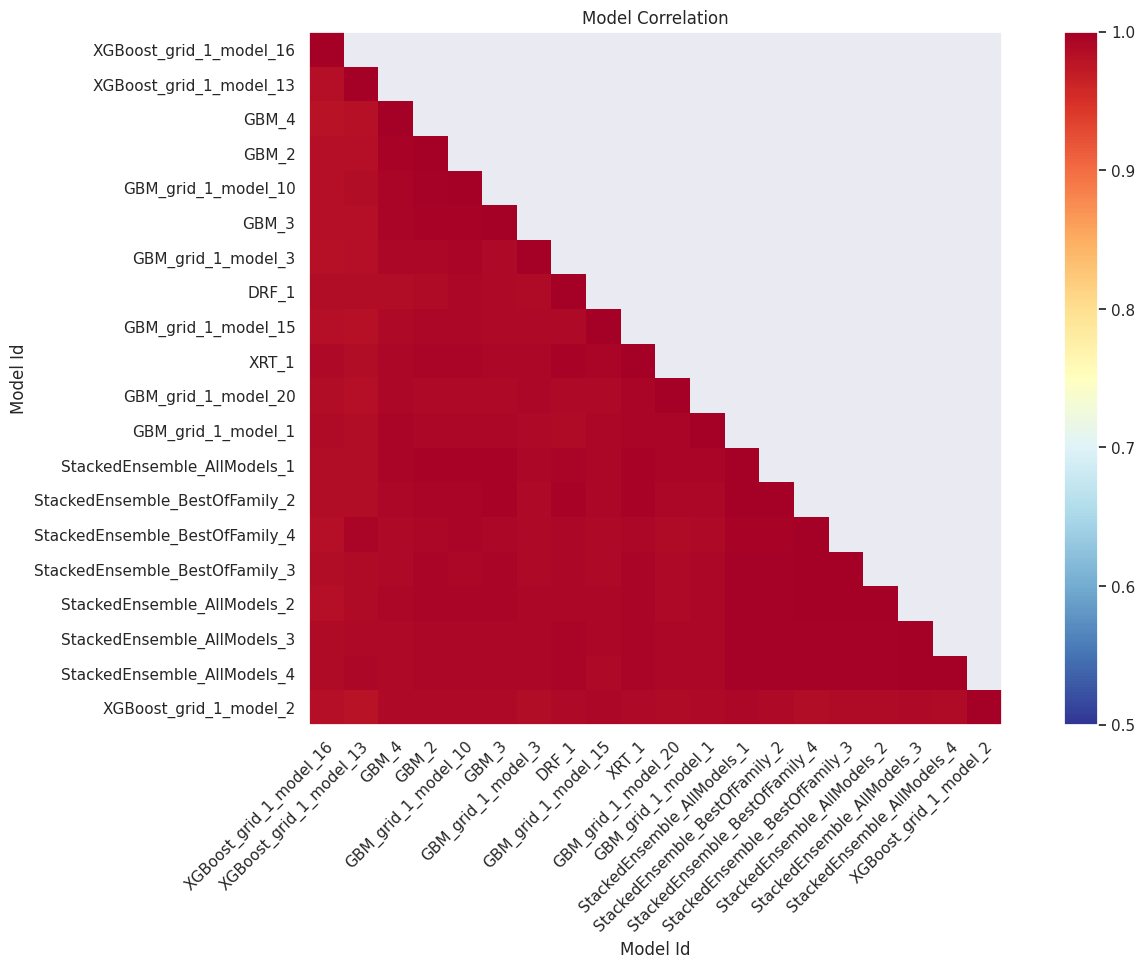

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

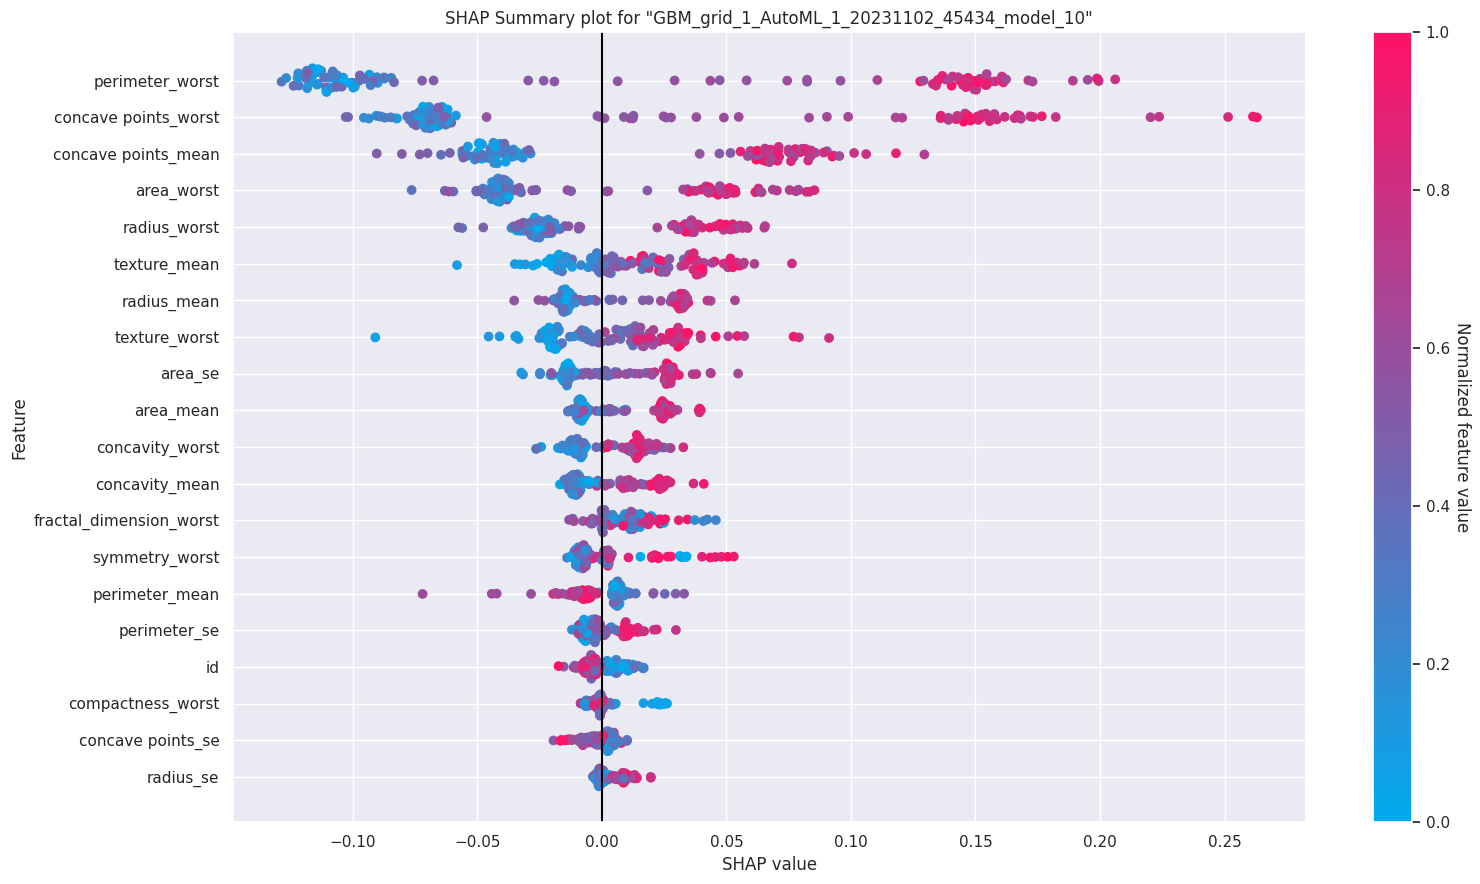

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

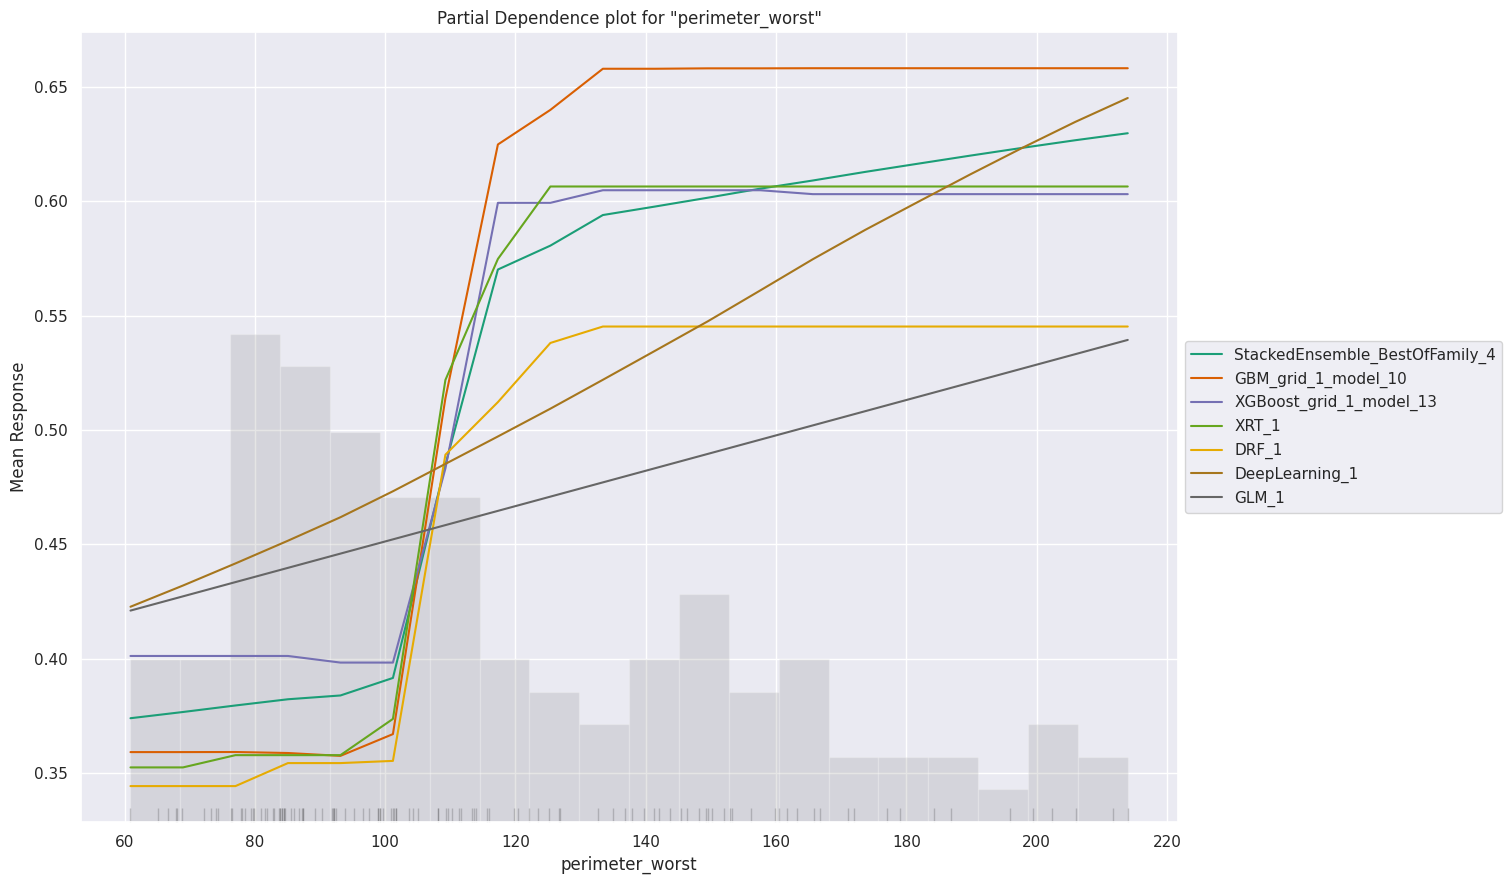

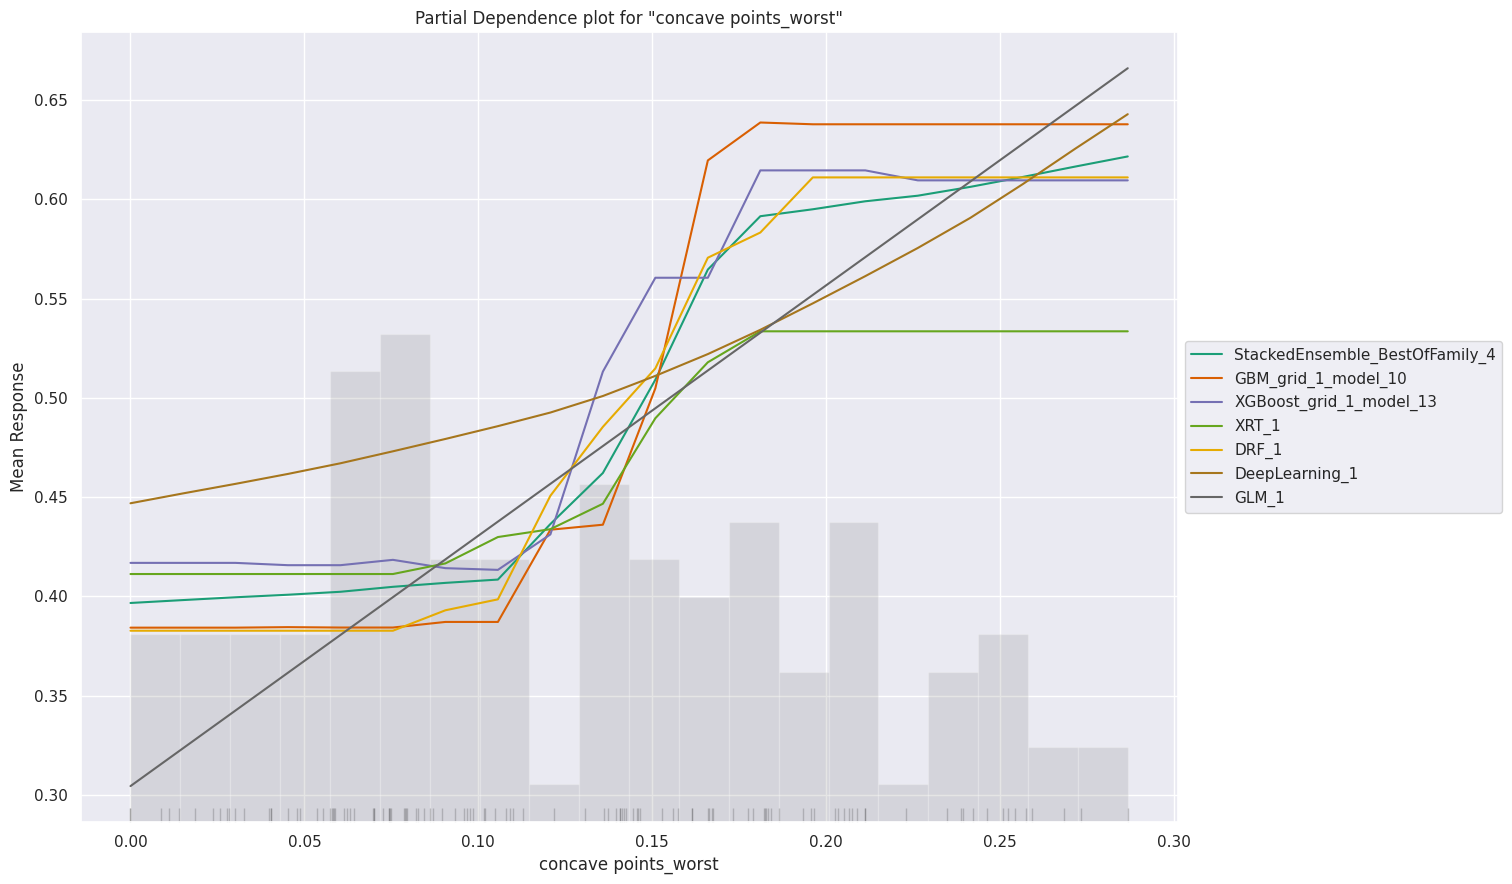

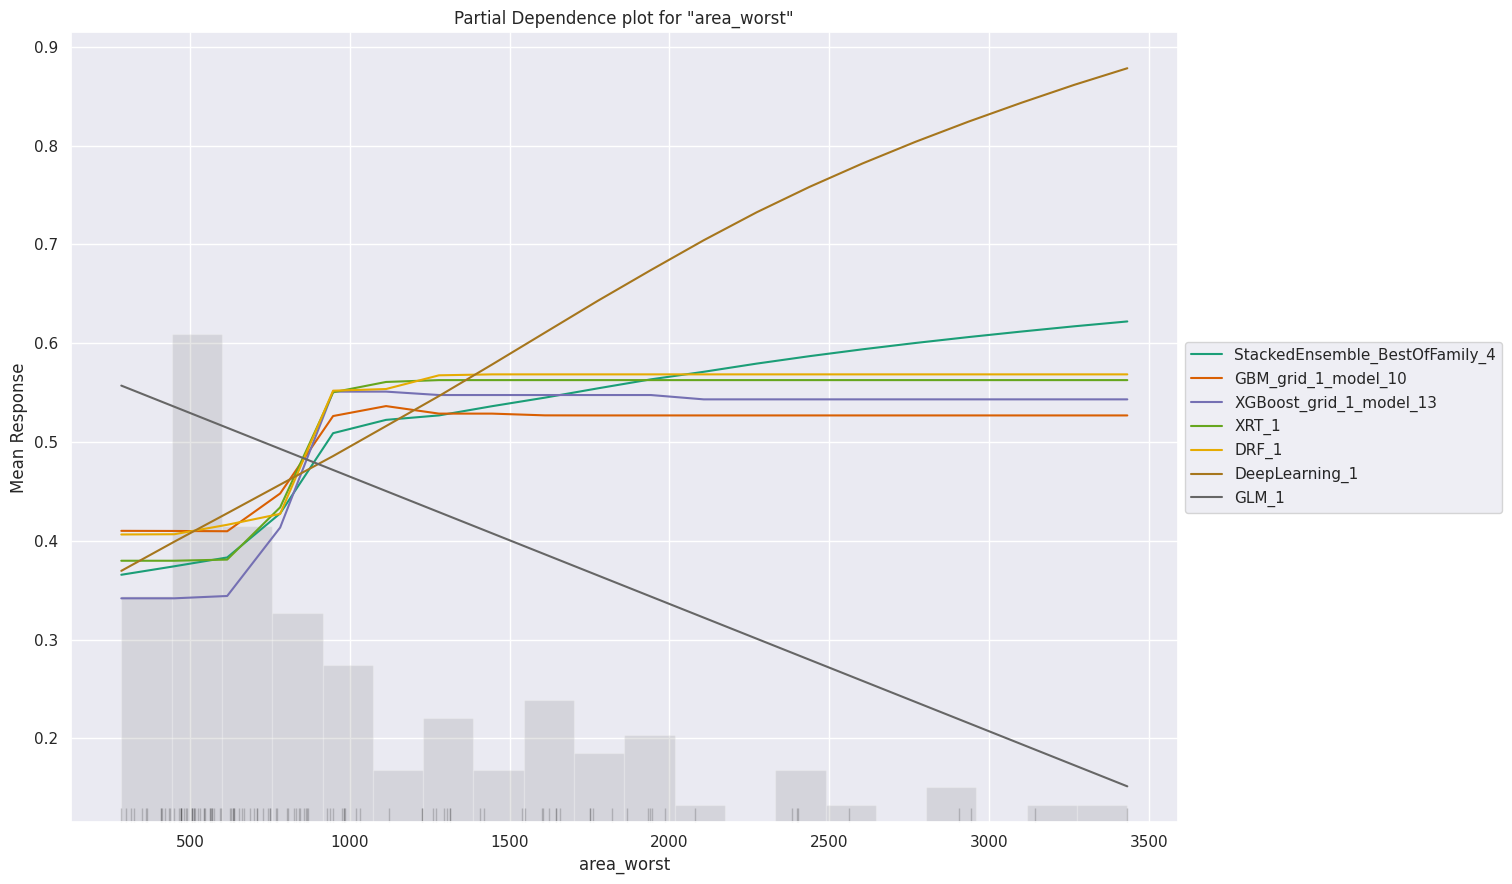

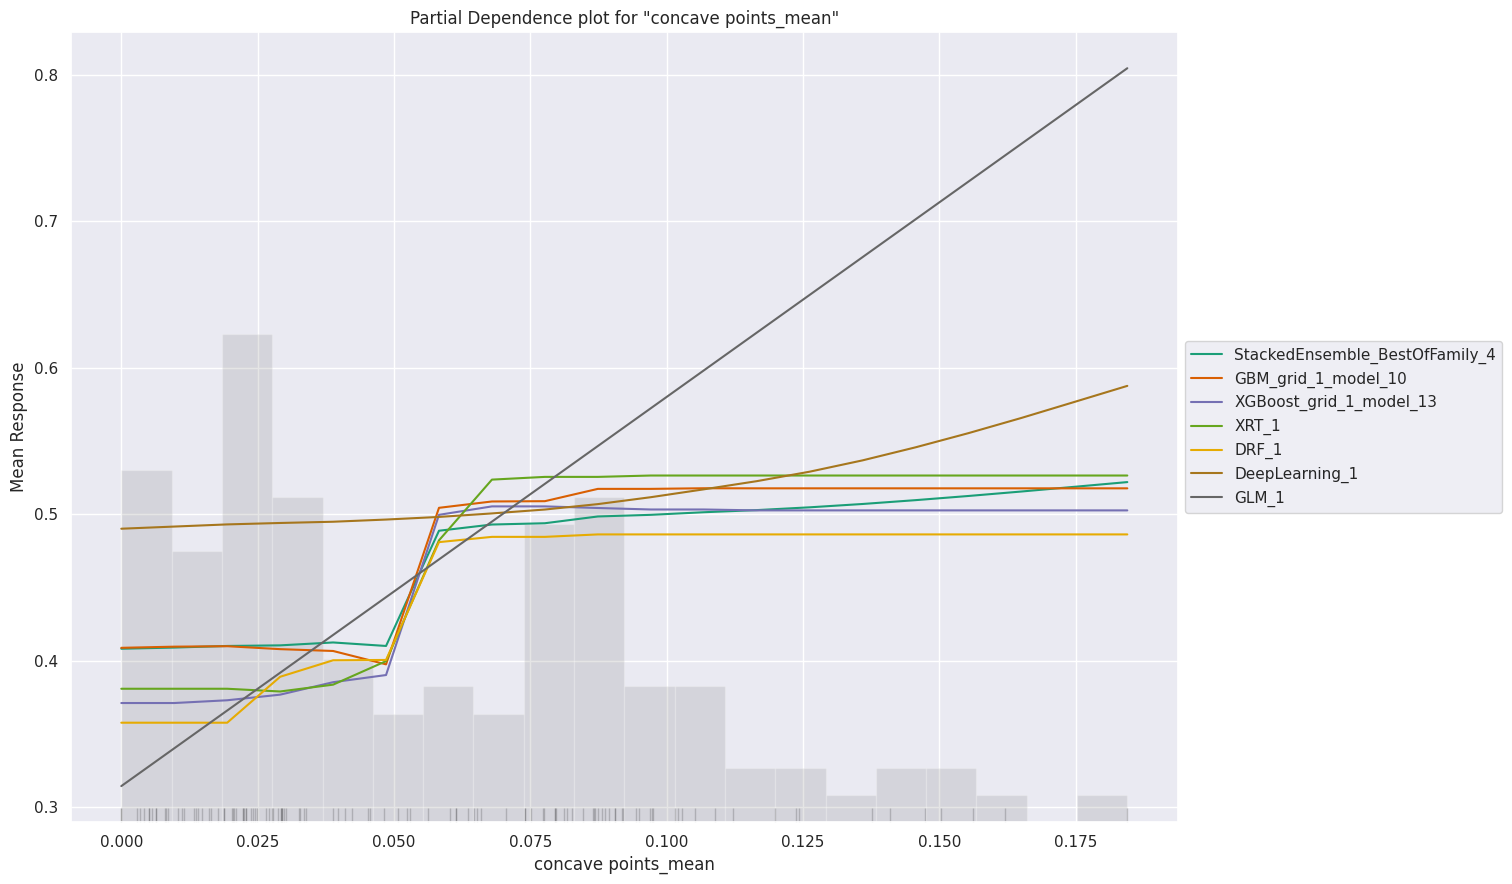

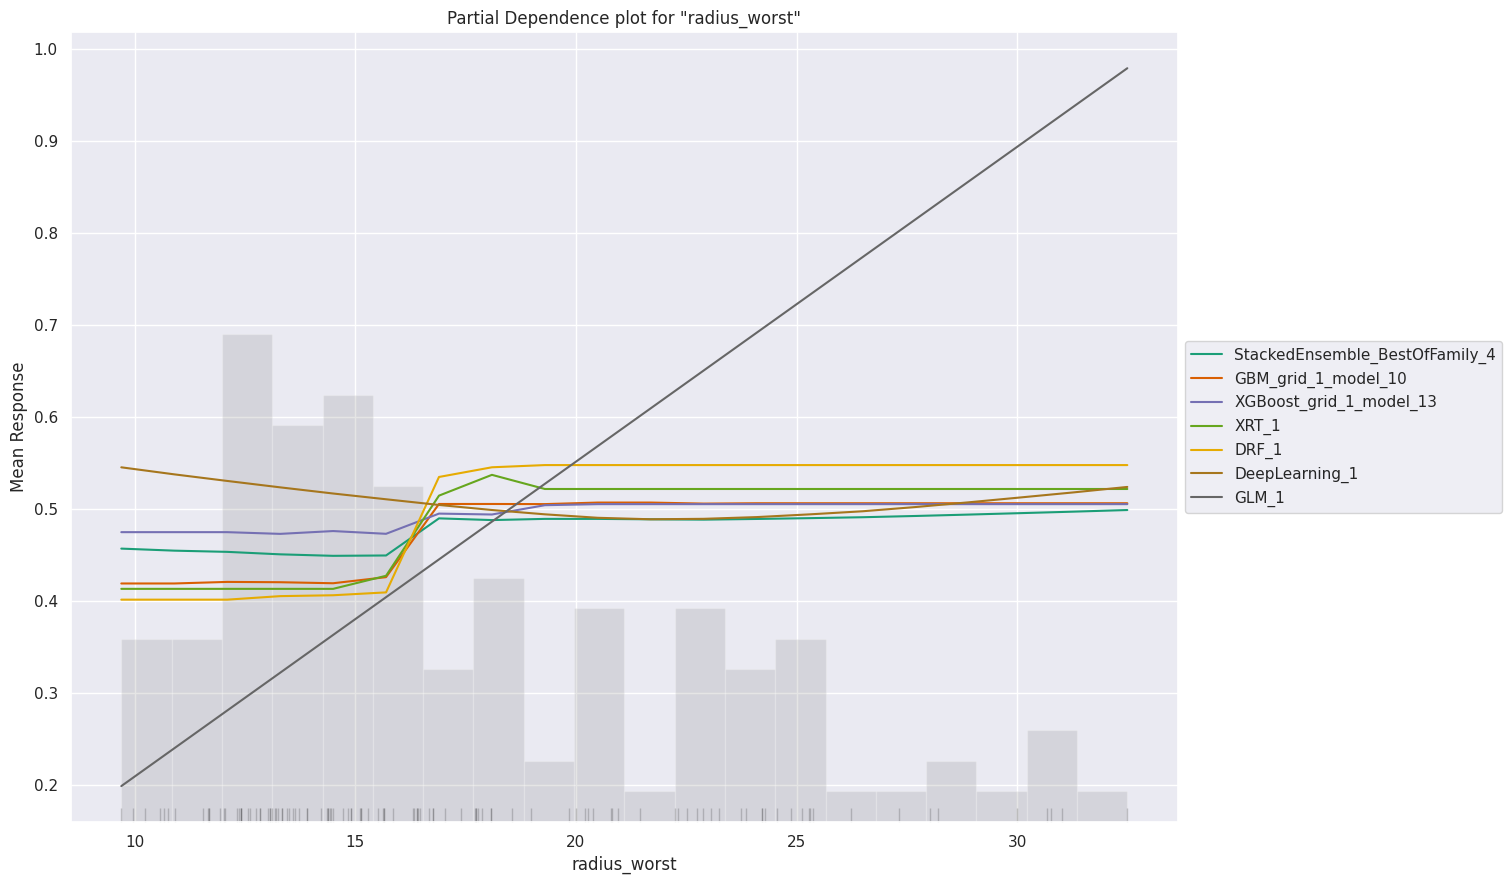

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

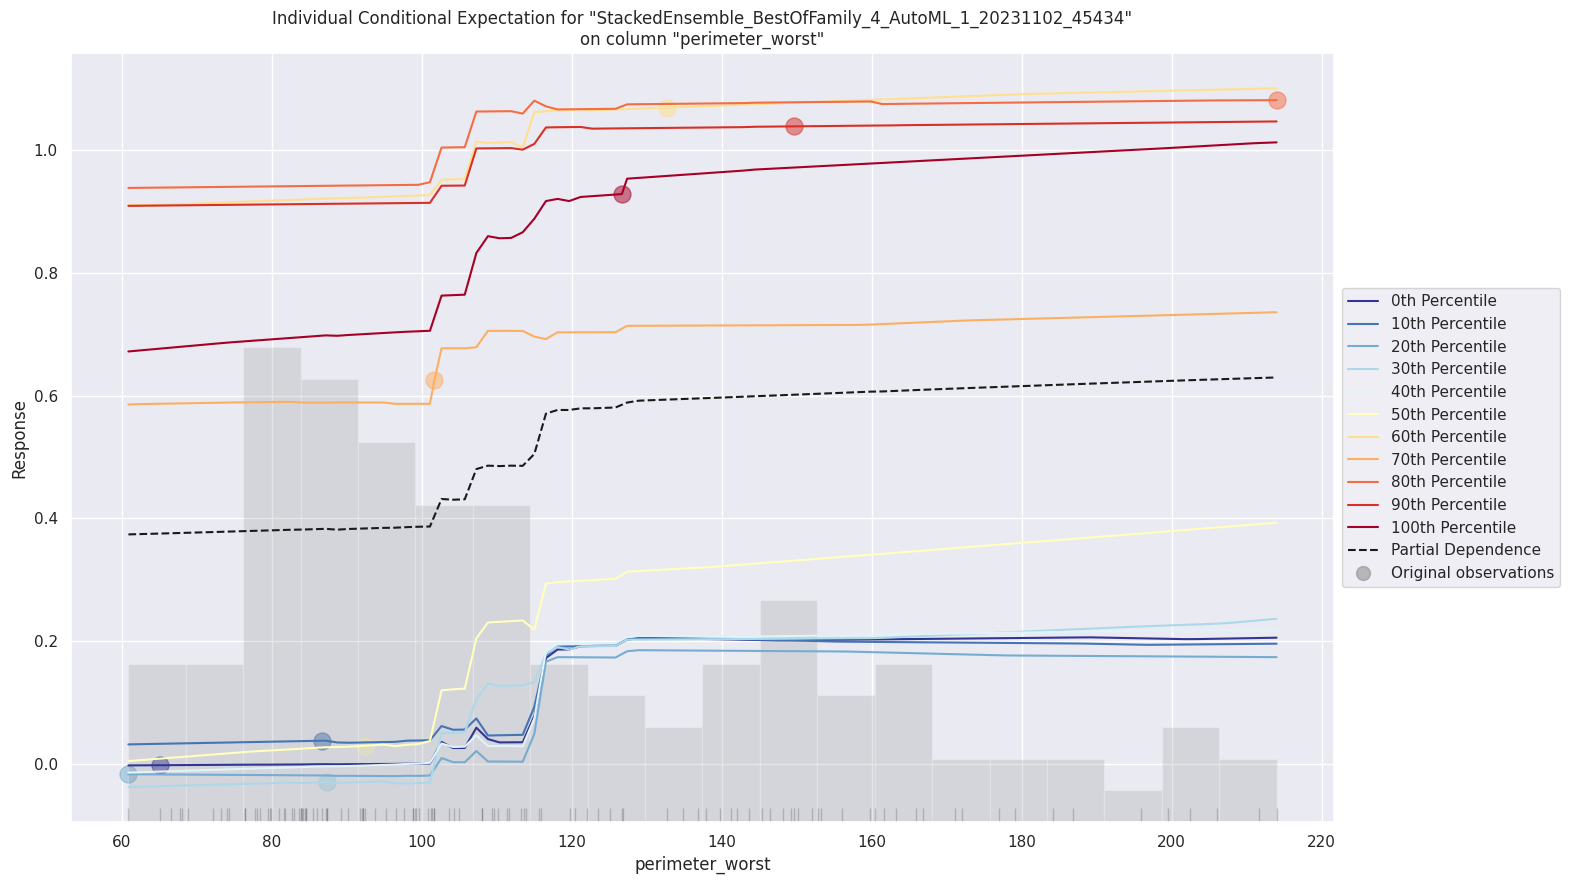

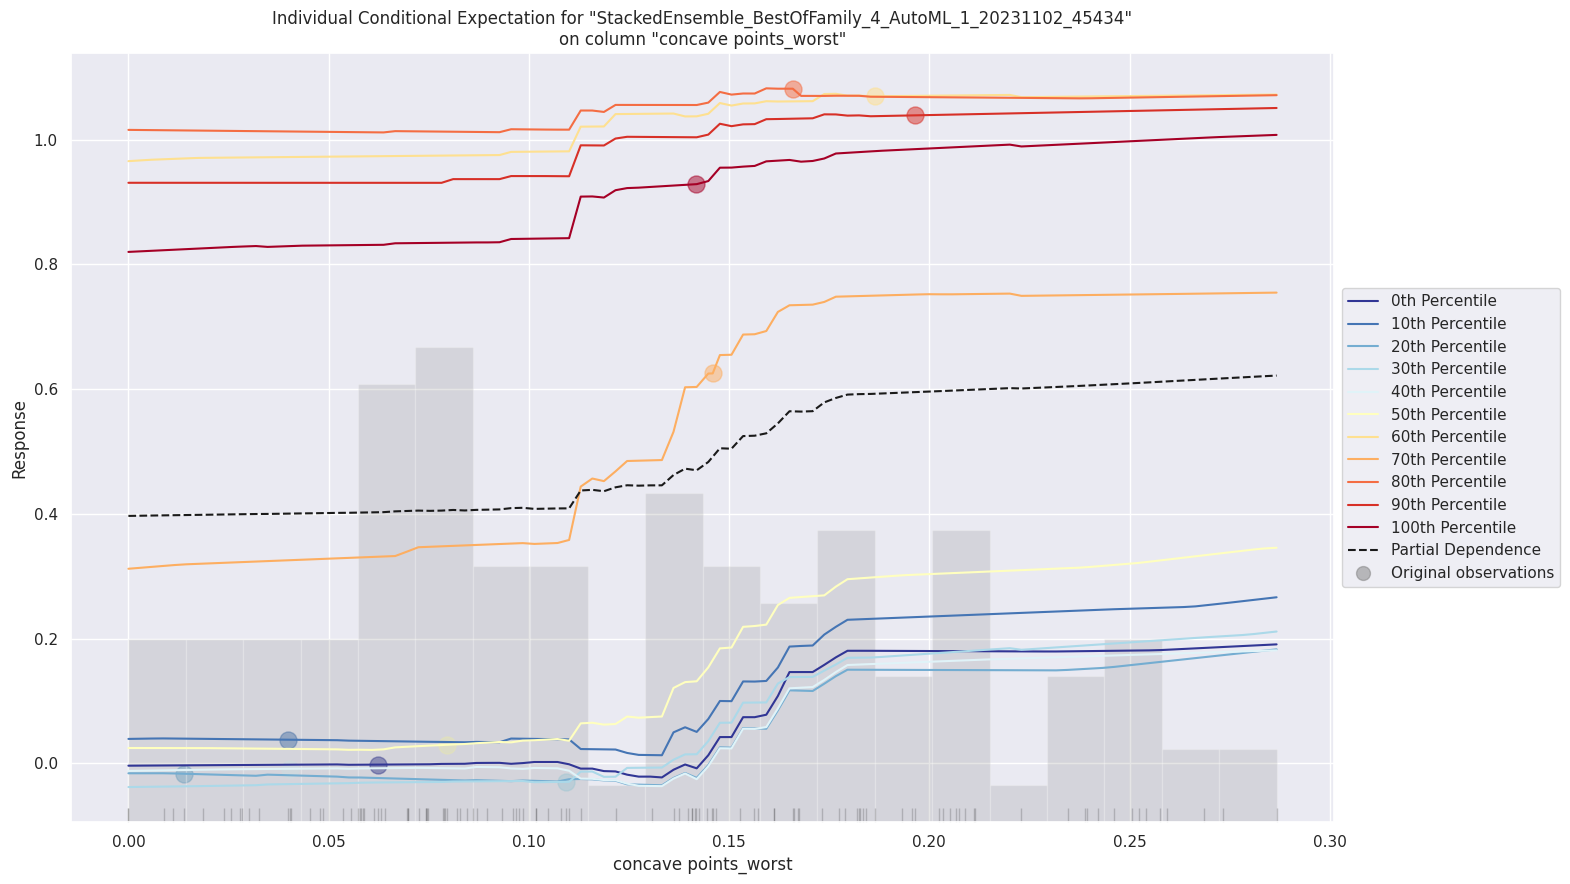

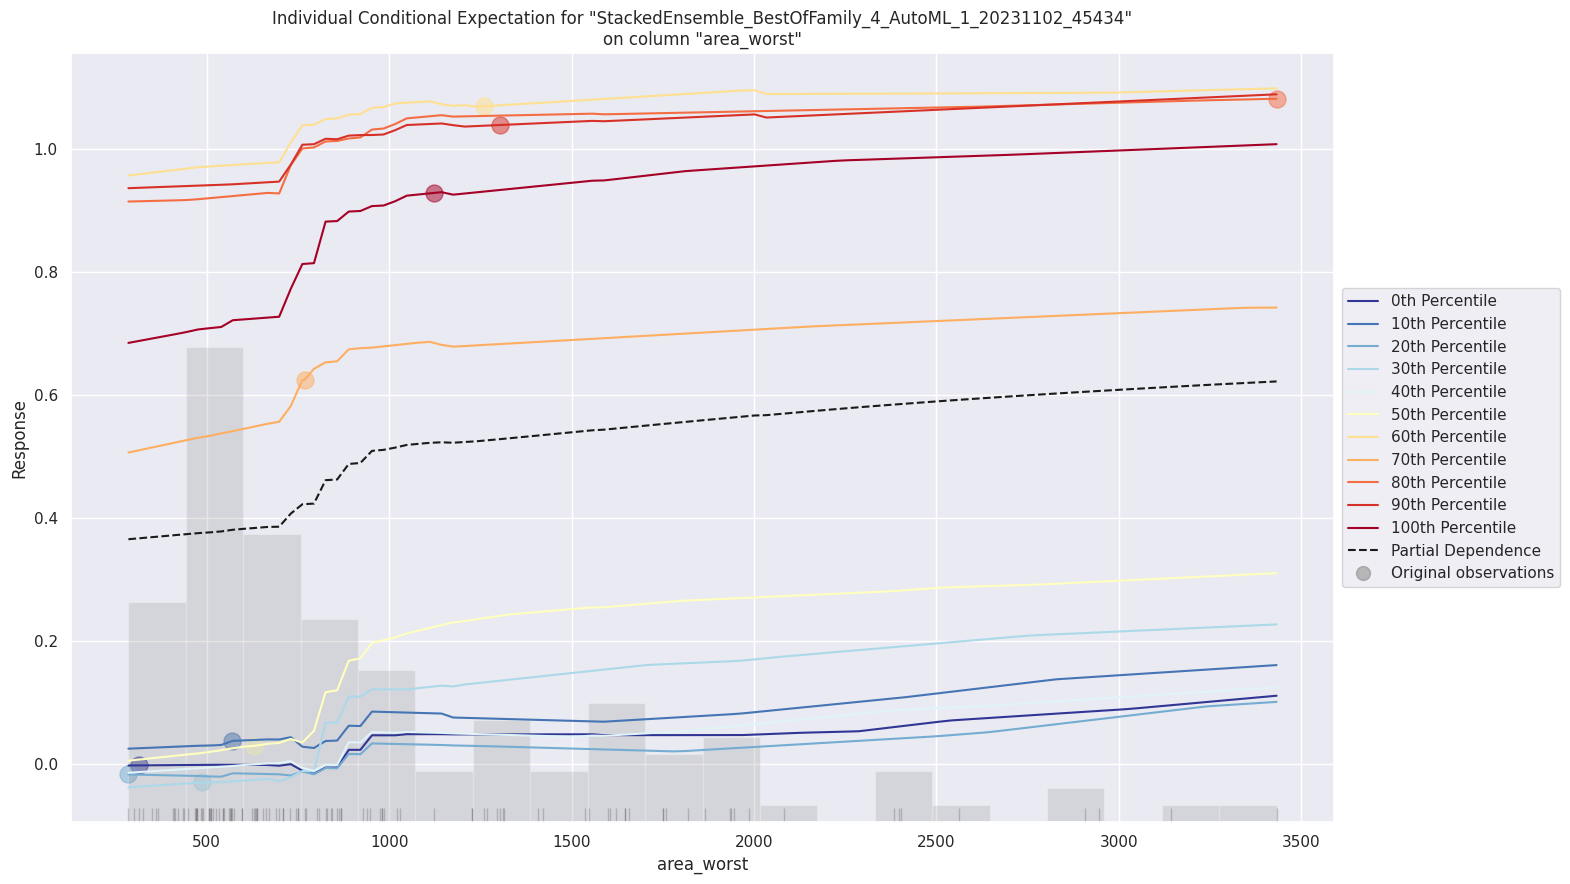

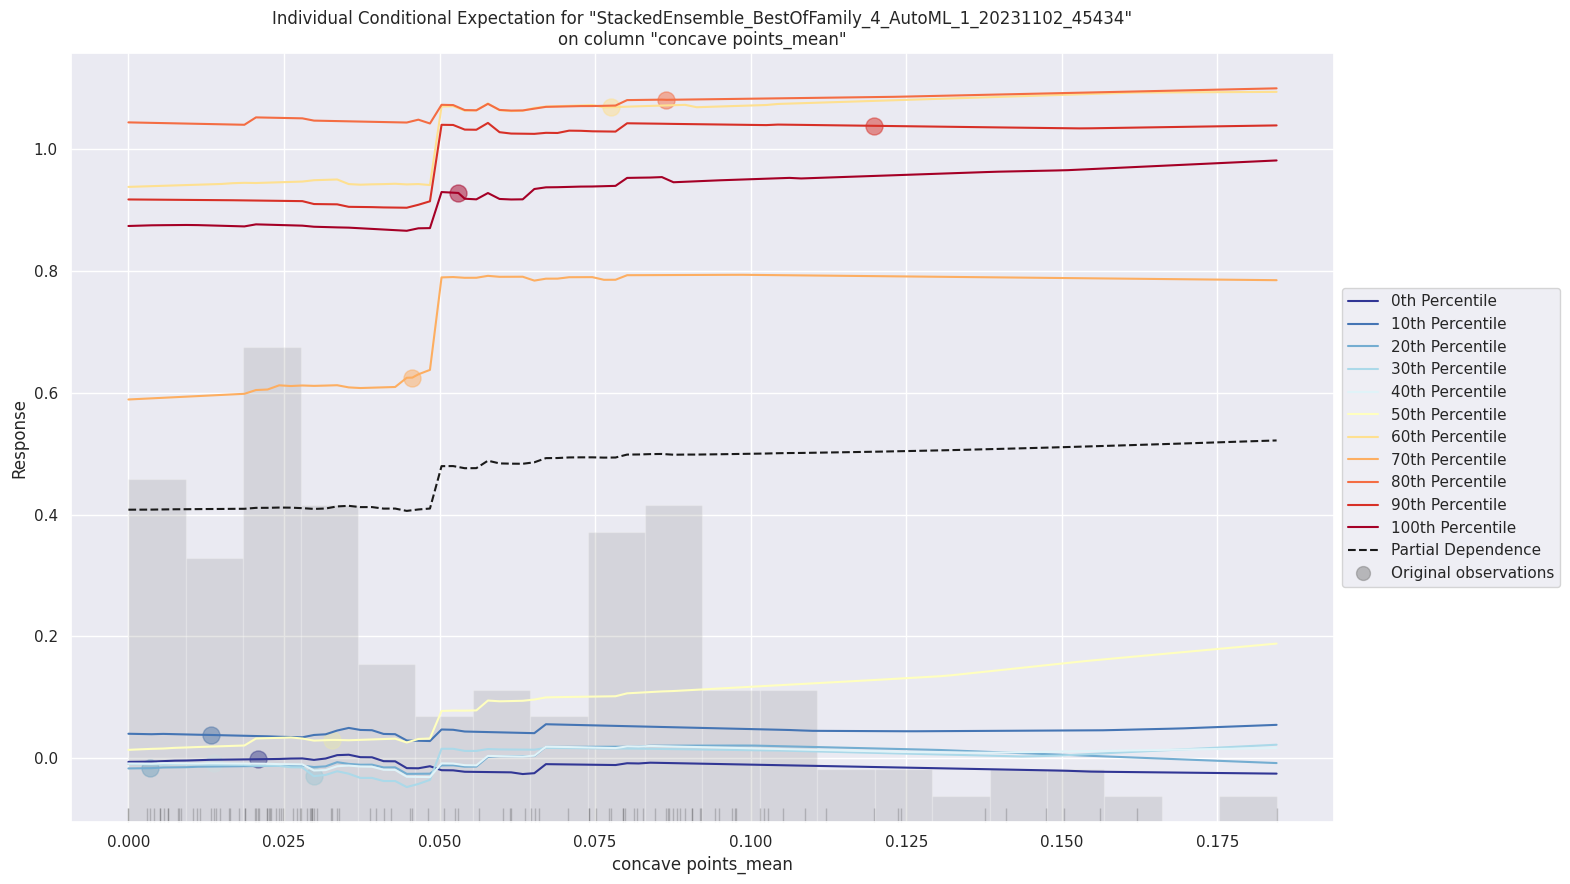

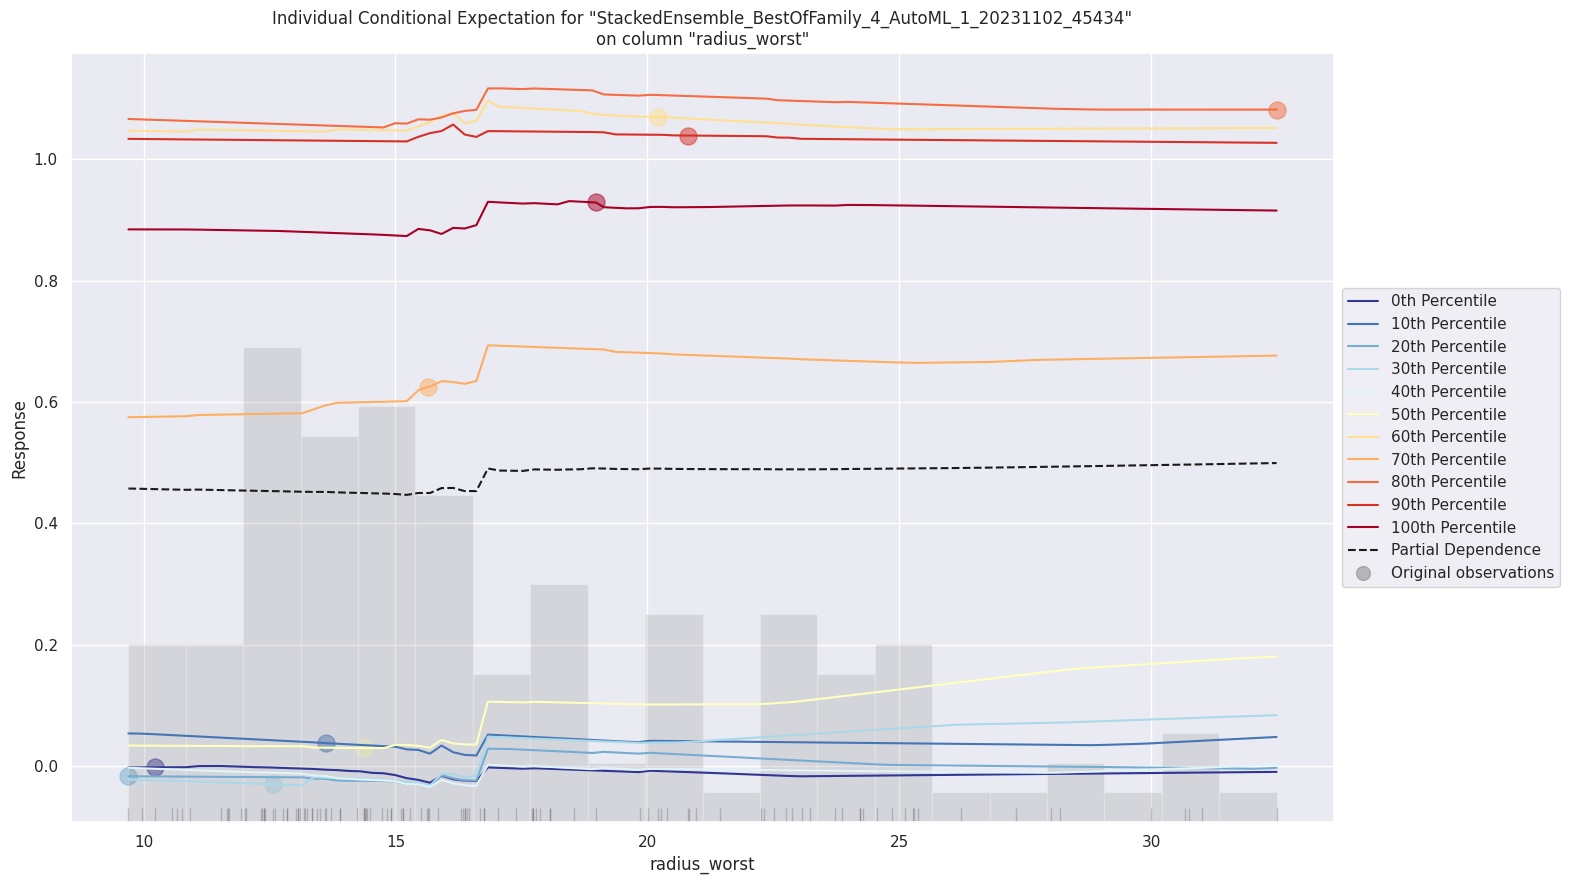

In [ ]:
#calling explain method(The explain method generates explanations for the predictions made by the best model identified by the AutoML process.)
exa = aml.explain(df_test)

# **Interpreting Best Model from AutoML**

## **Residual Analysis**

Here, we can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. It can also be observed from the above graph that residuals are normally distributed. Visuals signify that residuals don't have heteroscedasticity since the plot has striped lines and there is no cone shaped residual plot.

## **SHAP Summary**

From the SHAP summary diagram, we can interpret a few conclusions

- **Feature Importance:** The features are ranked by importance starting from the top to the bottom. The **perimeter_worst** stands out as the most influential predictor in the model, followed by concave_points_worst, concave_points_mean, and so forth. The feature **radius_se** seems to be the least significant in impacting the model’s predictions.
- Higher values of **perimeter_worst** seem to consistently push predictions higher (as shown by the concentration of pink/red dots to the right).
- When I observed **concave_points_mean**, I noticed that higher values (more pink/red) pushes the prediction higher, while the opposite holds true for its lower values.
- Some features like **texture_mean** shows SHAP values on both sides of the center, indicating there are specific values of **texture_mean** which can lead to a significant increase or decrease in the prediction.
- Higher values of **area_se** (represented in pink/red), there is a mix of positive and negative impacts, indicating this feature's complex relationship with the model's prediction.


## **Partial Dependence Plot Analysis:**

A partial dependence plot shows the marginal effect of a feature on the target(Diagnosis in our dataset). It is achieved by keeping all other variables constant and changing the value of one variable to get its PDP.

For Interpretation purposes, let us pick up the one of the most important variables - "**perimeter_worst**".

- **Feature in Focus:** The feature is "**perimeter_worst**".
- **Models Represented:** There are several models represented by different colored lines: StackedEnsemble_BestOfFamily_4, GBM_grid_1_model_10, XGBoost_grid_1_model_13, XRT_1, DRF_1, DeepLearning_1, and GLM_1.
- **Mean Response:** The vertical axis represents the mean response. As the "perimeter_worst" values increase, we observe the mean response changes for different models.
- **Trend Observation**: Most models show an increasing trend, implying that as the "perimeter_worst" value increases, the mean response also tends to increase. Especially, the StackedEnsemble_BestOfFamily_4, GBM_grid_1_model_10, and XGBoost_grid_1_model_13 models have quite similar behaviors.
- The light gray histogram in the background provides the distribution of the **"perimeter_worst"** values in the dataset. Peaks indicate regions with a higher density of data points.

The computation of partial dependence plots is intuitive: The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

## **Individual Conditional Expectation (ICE) Plot Analysis:**

This chart presents an Individual Conditional Expectation (ICE) plot focused on the feature "perimeter_worst" for the model "StackedEnsemble_BestOfFamily_4_AutoML_1_20231102_45434".

- **Feature in Focus:** The x-axis represents the "perimeter_worst" feature.

- **Response:** The y-axis indicates the response or predicted outcome.

- **Percentile Curves:** The colored lines represent individual observations' predicted outcomes at various percentiles (0th to 100th). Each line demonstrates how the predicted response changes for a particular observation across different "perimeter_worst" values.

- **Partial Dependence:** The dashed line represents the Partial Dependence of the model, showing the average effect of "perimeter_worst" on the predicted outcome.

- **Original Observations:** The circular markers represent original observations in the data. Their position on the x-axis indicates the "perimeter_worst" value and on the y-axis indicates the actual response.

- **Histogram Overlay:** The light gray histogram in the background visualizes the distribution of the "perimeter_worst" values. Peaks signify areas with a higher concentration of data points.

- **Trends:** For higher percentiles (like the 90th and 100th), the predicted response remains relatively constant across the "perimeter_worst" values.
Lower percentiles (like 0th to 40th) show a gradual increase in response as "perimeter_worst" increases.

- **Variability:** ICE plots highlight the variability in model predictions. Here, it's evident that the model responds differently to "perimeter_worst" for individual observations, especially in the range of 80 to 140, where most data points are concentrated.

In summary, the ICE plot provides insights into how "perimeter_worst" influences the model's predictions for individual data points.

##**Variable Importance Analysis using H2O Gradient Boosting Machine**

The visualization presents the significance of various features in predicting breast cancer using the Gradient Boosting Machine model.

The length of the blue bars indicates the relative importance of each variable, with longer bars representing higher importance.

- **Perimeter_worst:** This variable has the highest significance in predicting the outcome. It stands out as the **most dominant feature**, holding **maximum importance.**

- **Concave_points_worst:** The **second most important feature**, it's closely behind in significance compared to perimeter_worst.

- **Area_worst:** The worst measurements (the measurements of the largest value for each feature) play a crucial role in determining the **diagnosis**.

- **Concave_points_mean:** While not as significant,the mean value of concave points still plays a substantial role in the model.

- **Radius_worst:** Another 'worst' feature making, emphasizing the importance of these measurements.

- **Texture_worst, Radius_mean, Area_mean:** These features hold moderate importance in the predictive model.

- **Texture_mean and Concavity_mean:** These features have the **least significance** among the displayed variables.

 In conclusion, the model heavily weighs the 'worst' measurements, especially **perimeter_worst**, in its predictions, indicating that these are key factors in breast cancer detection.






In [ ]:
# OLS model Library
import statsmodels.formula.api as smf

In [ ]:
# converts an H2O data frame object (df) into a pandas data frame object (pandas_df).
import h2o

pandas_df = h2o.as_list(df)

In [ ]:
# Rename columns with spaces
pandas_df.columns = pandas_df.columns.str.replace(' ', '_')

# Then, generate the formula programmatically
dependent_var = 'diagnosis'
independent_vars = pandas_df.columns.drop(dependent_var)  # Drop the dependent variable
formula = dependent_var + ' ~ ' + ' + '.join(independent_vars)

# Run the regression
results = smf.ols(formula, data=pandas_df).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diagnosis   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     59.49
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          3.98e-152
Time:                        05:00:00   Log-Likelihood:                 29.849
No. Observations:                 569   AIC:                             4.303
Df Residuals:                     537   BIC:                             143.3
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.0179      0.428     -4.711      0.000      -2.859      -1.176
id                      -5.085e-11   8.31e-11     -0.612      0.541   -2.14e-10    1.12e-10
radius_mean                -0.2188      0.174     -1.260      0.208      -0.560       0.122
texture_mean                0.0047      0.008      0.595      0.552      -0.011       0.020
perimeter_mean              0.0237      0.025      0.945      0.345      -0.026       0.073
area_mean                   0.0003      0.001      0.614      0.539      -0.001       0.001
smoothness_mean             0.1063      2.019      0.053      0.958      -3.859       4.072
compactness_mean           -4.2390      1.335     -3.176      0.002      -6.861      -1.617
concavity_mean              1.4080      1.047      1.345      0.179      -0.648       3.464
concave_points_mean         2.1205      1.981      1.071      0.285      -1.770       6.011
symmetry_mean               0.1000      0.743      0.135      0.893      -1.360       1.560
fractal_dimension_mean     -0.0120      5.576     -0.002      0.998     -10.965      10.941
radius_se                   0.4254      0.311      1.368      0.172      -0.186       1.036
texture_se                 -0.0081      0.037     -0.218      0.827      -0.081       0.064
perimeter_se               -0.0227      0.041     -0.552      0.581      -0.104       0.058
area_se                    -0.0008      0.001     -0.587      0.557      -0.004       0.002
smoothness_se              16.1685      6.649      2.432      0.015       3.108      29.229
compactness_se              0.0281      2.172      0.013      0.990      -4.238       4.294
concavity_se               -3.5793      1.302     -2.750      0.006      -6.136      -1.022
concave_points_se          10.8305      5.472      1.979      0.048       0.081      21.580
symmetry_se                 1.6484      2.730      0.604      0.546      -3.715       7.012
fractal_dimension_se       -6.9457     11.688     -0.594      0.553     -29.905      16.014
radius_worst                0.1959      0.058      3.377      0.001       0.082       0.310
texture_worst               0.0072      0.007      1.031      0.303      -0.006       0.021
perimeter_worst            -0.0024      0.006     -0.411      0.682      -0.014       0.009
area_worst                 -0.0010      0.000     -3.171      0.002      -0.002      -0.000
smoothness_worst            0.5288      1.436      0.368      0.713      -2.291       3.349
compactness_worst           0.0736      0.383      0.192      0.848      -0.680       0.827
concavity_worst             0.3807      0.269      1.416      0.157      -0.147       0.909
concave_points_worst        0.4490      0.915      0.491      0.624      -1.349       2.247
symmetry_worst              0.5634      0.495  

results.summary(): This line prints a summary of the regression results to the console. The summary method is called on the results object, which generates a report that includes information such as the coefficients and standard errors of the regression equation, goodness-of-fit measures, and diagnostic statistics. This summary report can be useful for understanding the relationships between the dependent and independent variables, and for assessing the quality of the regression model.



##**Are any model assumptions violated?**

**Model Assumptions**

- We can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. Here no **heteroscadasticity** is observed in the residual plot, hence this assumption is not violated.

- If we look closely at the Heat map- We can see that from the plots, we do not have much high correlation between features.
If we look closely at the Pair-Plot - we can notice that every predictor variable has linear relationship with the target variable.

- **Durbin- Watson value is 1.799**, which signifies that there is **positive autocorrelation** in our data, hence this assumption is not violated.

- Based on the distributions I described earlier, it is possible that some of the variables violate the assumption of normality. For example, there are paramters like p**erimeter_worst** that have positively skewed distributions, which could lead to non-normality of the residuals in a linear regression model.

In [ ]:
# Separating the predictor and target variables
X = pandas_df.drop(['diagnosis'], axis=1)
y = pandas_df['diagnosis']

In [ ]:
from sklearn.model_selection import train_test_split as tts

# Splitting the data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


In [ ]:
import statsmodels.api as sm

cols1 = [col for col in pandas_df.columns if col != 'diagnosis']

X_train_const = sm.add_constant(X_train[cols1])
model1 = sm.OLS(y_train, X_train_const).fit()


In [ ]:
y_pred = model1.predict(sm.add_constant(X_train[cols1]))


In [ ]:
residuals = y_train - y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))


Mean of Residuals 3.320024499520424e-11


<ipython-input-78-0619e176278d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(residuals, kde=True)


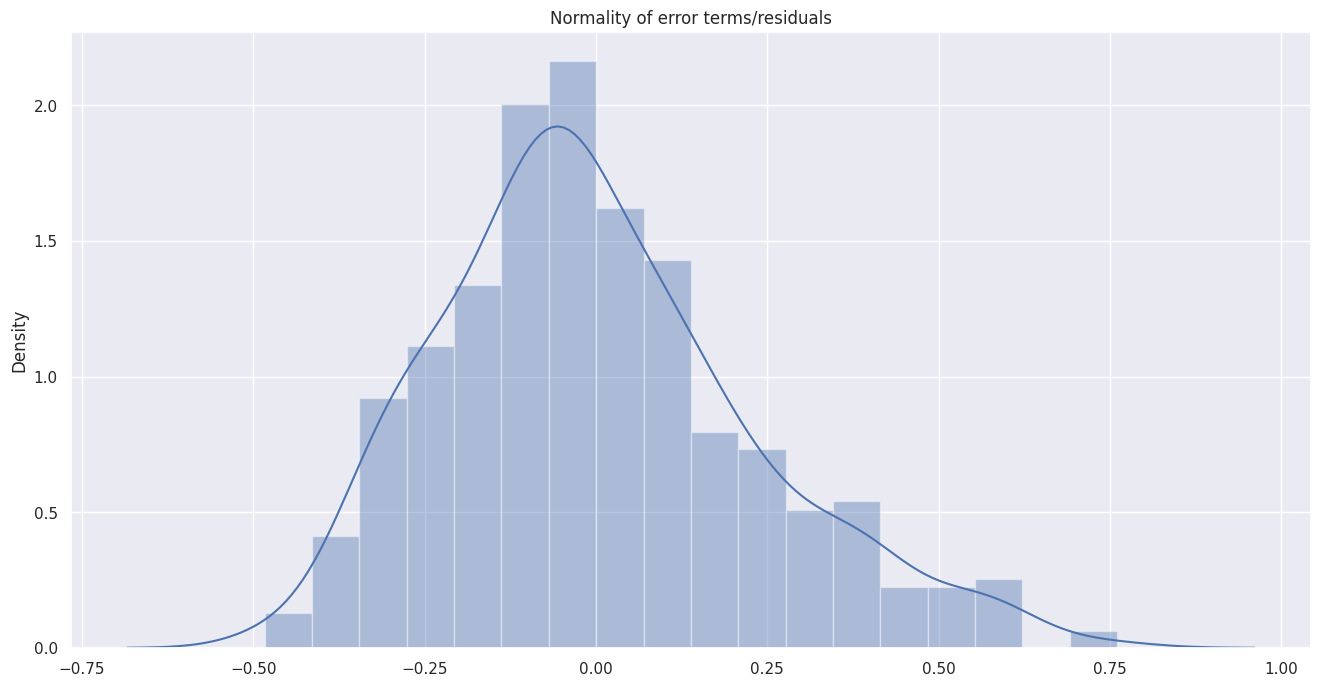

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

p = sns.distplot(residuals, kde=True)
p = plt.title('Normality of error terms/residuals')
plt.show()


For the above graph:

- **Histogram:** The blue bars represent the frequency distribution of error terms or residuals in the model.
- **Curve:** The dark curve represents the ideal normal distribution.
- **Central Tendency:** Most of the error terms are clustered around the center (0.00), suggesting that a significant portion of predictions were fairly accurate.
- **Skewness: **The distribution is approximately symmetrical, with a slight skew towards the right. This implies there might be slightly more positive residuals than negative ones.
- **Density on Y-Axis:** The y-axis shows the density, which gives an idea about the distribution's shape. Higher density values indicate where most of the data points are concentrated.
- **Residual Values on X-Axis:** The x-axis ranges from -0.75 to 1.00, representing the values of the residuals. The central value is 0.00, indicating no error.

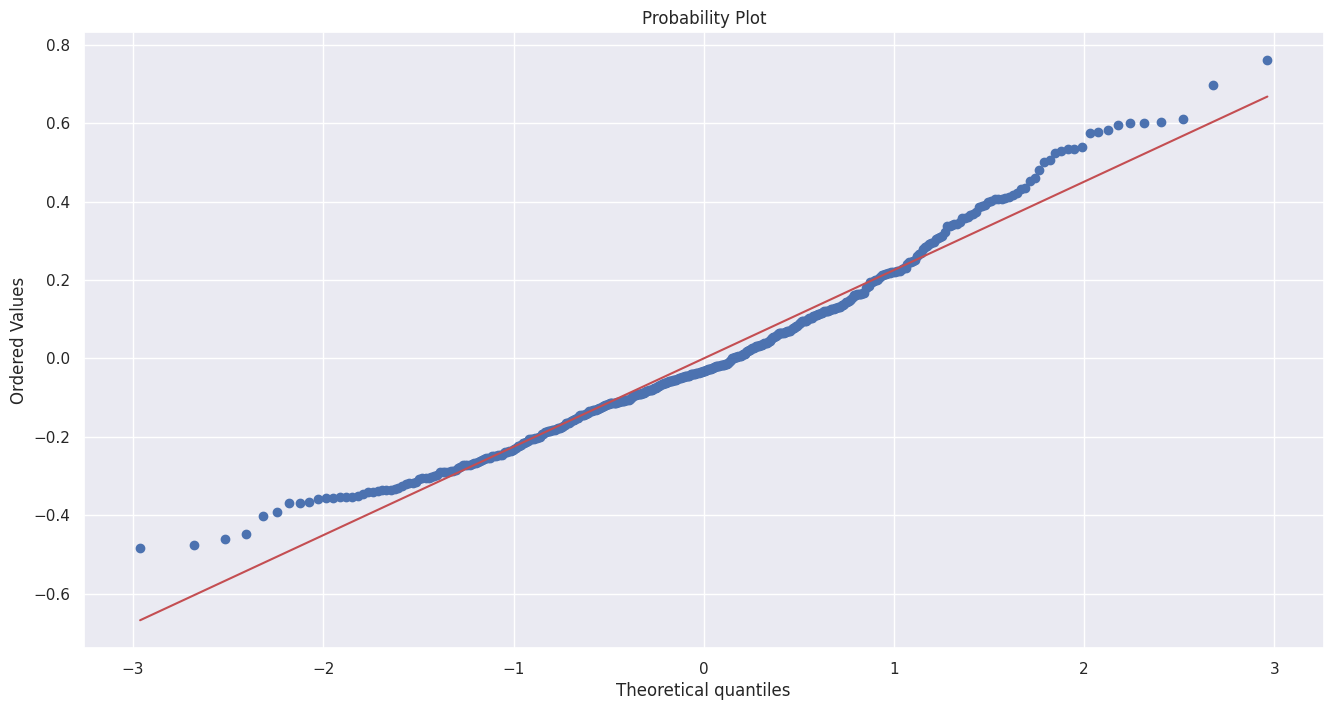

In [ ]:
import pylab
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()


- The Probability Plot indicates that the data is mostly normal but has some deviations, especially in the higher range.
- The presence of data points away from the red line in the tails might suggest potential outliers or a non-normal distribution in those regions.


## **Insights:**

- Blue Dots: These represent the ordered values (possibly residuals or another dataset) from the dataset.
- Red Line: Represents the theoretical quantiles from a standard normal distribution.
- Theoretical Quantiles (X-axis): The x-axis shows the quantiles from a standard normal distribution, ranging from around -3 to 3. This usually covers the 99.7% range of data in a normal distribution.
- Ordered Values (Y-axis): The y-axis represents the ordered values from the data, ranging approximately from -0.6 to 0.8.
- Trend and Deviations: For a significant portion of the plot, the blue dots follow the red line closely, indicating that the data is approximately normally distributed. However, at the higher end (right tail) of the distribution, there is a clear deviation from the red line, suggesting the presence of outliers or a slight skewness in the data towards higher values.


<Axes: xlabel='perimeter_worst', ylabel='Count'>

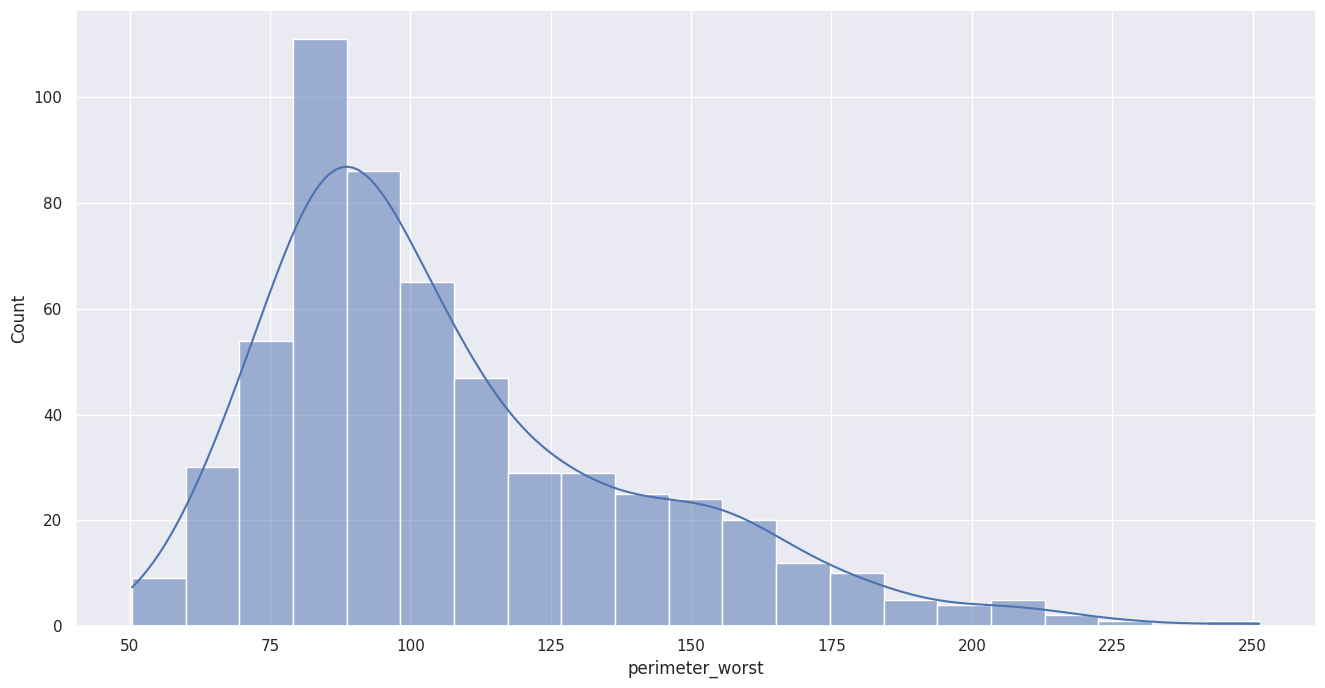

In [ ]:
import seaborn as sns

sns.histplot(pandas_df['perimeter_worst'], kde=True)


##**The main observations from the plot:**

- **Histogram Bars:** The blue bars of the histogram represent the frequency (or count) of data points falling within specific bins or intervals of the **"perimeter_worst"** variable.
- **Curve:** The dark line represents a theoretical or fitted distribution curve, possibly a normal distribution.
- **X-axis ("perimeter_worst"):** The values range from around 50 to approximately 250. It represents the 'worst' or largest mean value of perimeter measurements from the dataset.
- **Y-axis ("Count"):** Indicates the number of data points falling within each bin. The peak is around 100, suggesting that the most frequent "perimeter_worst" values lie in that range.
- **Distribution Shape:** The data appears to have a right-skewed distribution, as evidenced by the longer tail on the right side of the peak. The bulk of the data lies between 75 and 150, with fewer data points as the "perimeter_worst" value increases beyond 150.
- **Curve Fit:** The curve seems to fit the central part of the histogram reasonably well, there are deviations in the tails, particularly in the right tail. This implies that the actual data distribution is not perfectly normal, due to its right skewness.



#**Hyperparameter Tuning - Random Grid Search on GBM Model**


The goal of **hyperparameter tuning** is to find the hyperparameters that produce the best performance on the test set, while avoiding overfitting on the training set. It is an important step in the machine learning pipeline, as the choice of hyperparameters can have a significant impact on the accuracy and generalization of a machine learning model.

In [ ]:
#train test and split
train, validate, test = np.split(
    pandas_df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# The values of these keys are lists that contain different values for each hyperparameter that can be used to train a gradient boosting machine (GBM) model.
gbm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

The purpose of creating this dictionary is to specify a grid of hyperparameters that can be used to train a GBM model. The ranges are taken randomly for each parameter(by printing each parameter you can understand the ranges). By combining different values for each hyperparameter, we can search for the combination that yields the best performance on a validation set. This process is known as hyperparameter tuning, and it's a common technique used to improve the performance of machine learning models.



In [ ]:
search_criteria = {"strategy": "RandomDiscrete", "max_models": 36, "seed": 1}

Together, these search criteria specify a random search process that will train a maximum of 36 GBM models, randomly sampling hyperparameters from the grid defined in gbm_parameters. The goal of this process is to find the combination of hyperparameters that yields the best performance on a validation set, in order to create a well-performing GBM model.

In [ ]:
#  creating the H2OGridSearch object
gbm_grid2 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid2",
    hyper_params=gbm_parameters,
    search_criteria=search_criteria,
)

In [ ]:
# Might give an error, please try reloading if that happens.

feature_columns = train.columns
feature_columns.remove(y)  # Assuming 'y' has the correct target column name



In [ ]:
gbm_grid2.train(
    x=feature_columns,
    y=y,
    training_frame=train,
    validation_frame=validate,
    ntrees=100,
    seed=1
)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids           residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------  --------------------
     0.5                  0.1           9.0          1.0                 gbm_grid2_model_7   0.02404225865422452
     0.1                  0.07          7.0          0.8                 gbm_grid2_model_9   0.02474241098510057
     0.1                  0.06          8.0          0.9                 gbm_grid2_model_34  0.02510879837364267
     0.4                  0.08          6.0          0.9                 gbm_grid2_model_28  0.025315082830309654
     0.9                  0.09          8.0          0.9                 gbm_grid2_model_36  0.02582439617979488
     0.2                  0.04          5.0          0.9                 gbm_grid2_model_29  0.025997145419735468
     0.1                  0.08          3.0          0.8                 gbm_grid2_model_13  0.026166196714702637
     0.9                  0.1           4.0          0.7000000000000001  gbm_grid2_model_15  0.026656514119000954
     0.6000000000000001   0.1           4.0          1.0                 gbm_grid2_model_22  0.027222108368913134
     0.9                  0.04          4.0          0.9                 gbm_grid2_model_31  0.02755866522005243
---  ---                  ---           ---          ---                 ---                 ---
     0.1                  0.02          9.0          0.8                 gbm_grid2_model_16  0.03632673771580498
     0.8                  0.04          2.0          0.9                 gbm_grid2_model_4   0.03632951036533824
     0.5                  0.03          2.0          0.6000000000000001  gbm_grid2_model_26  0.03750642648876974
     0.2                  0.02          10.0         0.5                 gbm_grid2_model_25  0.0416052616644625
     0.30000000000000004  0.02          2.0          1.0                 gbm_grid2_model_20  0.0421250694640062
     0.5                  0.02          2.0          0.9                 gbm_grid2_model_35  0.04386962000540805
     0.5                  0.01          10.0         1.0                 gbm_grid2_model_24  0.06513346064121721
     0.6000000000000001   0.01          9.0          0.8                 gbm_grid2_model_11  0.0658678909836165
     1.0                  0.01          2.0          0.5                 gbm_grid2_model_23  0.07028244056364359
     1.0                  0.01          2.0          0.7000000000000001  gbm_grid2_model_10  0.07172643349763258
[36 rows x 7 columns]

In [ ]:
#access information about best model
gbm_gridperf2 = gbm_grid2.get_grid()

In [ ]:
print(gbm_gridperf2)

Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids           residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------  --------------------
     0.5                  0.1           9.0          1.0                 gbm_grid2_model_7   0.02404225865422452
     0.1                  0.07          7.0          0.8                 gbm_grid2_model_9   0.02474241098510057
     0.1                  0.06          8.0          0.9                 gbm_grid2_model_34  0.02510879837364267
     0.4                  0.08          6.0          0.9                 gbm_grid2_model_28  0.025315082830309654
     0.9                  0.09          8.0          0.9                 gbm_grid2_model_36  0.02582439617979488
     0.2                  0.04          5.0          0.9                 gbm_grid2_model_29  0.025997145419735468
     0.1               

**Observations:**

The output is clearly seen that hyper-parameter search summary is ordered by increasing residual_deviance there by indicating the order of best performing models sorted by its performance

In [ ]:
#iterating the 36 parameters
list_hyperparameters = []
for i in range(36):
    hyperparameters = gbm_gridperf2.get_hyperparams_dict(i)
    list_hyperparameters.append(hyperparameters)

Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperp

In [ ]:
models = gbm_gridperf2.models

In [ ]:
#printing the list of models residual_deviance
list_residual_deviance = []
for i in range(36):
    model = models[i]
    performance_metrics = model.model_performance(validate)
    residual_deviance = performance_metrics.mean_residual_deviance()
    list_residual_deviance.append(residual_deviance)

In [ ]:
for i in range(36):
    list_hyperparameters[i]["Residual_Deviance"] = list_residual_deviance[i]

In [ ]:
hyperparameters_dataframe = pd.DataFrame(list_hyperparameters)

In [ ]:
print(hyperparameters_dataframe)

    col_sample_rate  learn_rate  max_depth  sample_rate  Residual_Deviance
0               0.5        0.10          9          1.0           0.024042
1               0.1        0.07          7          0.8           0.024742
2               0.1        0.06          8          0.9           0.025109
3               0.4        0.08          6          0.9           0.025315
4               0.9        0.09          8          0.9           0.025824
5               0.2        0.04          5          0.9           0.025997
6               0.1        0.08          3          0.8           0.026166
7               0.9        0.10          4          0.7           0.026657
8               0.6        0.10          4          1.0           0.027222
9               0.9        0.04          4          0.9           0.027559
10              0.6        0.09          3          0.9           0.028822
11              0.6        0.09          3          0.8           0.029076
12              0.9      

- The model with the **lowest Residual Deviance (best fit)** has the hyperparameters: **col_sample_rate=0.5, learn_rate=0.10, max_depth=9, and sample_rate=1.0** with a Residual Deviance of **0.024042.**

- The model with the **highest Residual Deviance (worst fit)** has the hyperparameters: **col_sample_rate=1.0**, **learn_rate=0.01**, **max_depth=2**, and ample_rate=0.7 bold text with a **Residual Deviance of 0.071726**

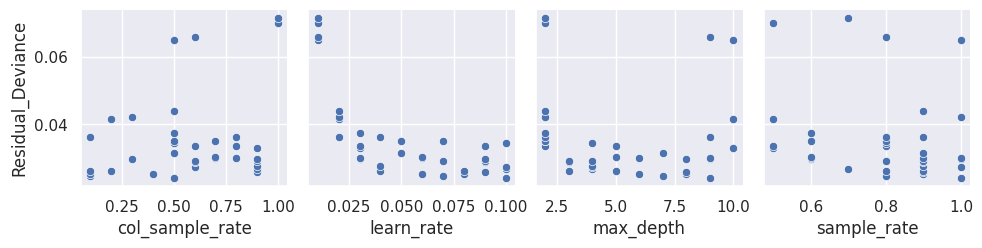

In [ ]:
#plotting a grid of scatter plot
sns.pairplot(
    hyperparameters_dataframe,
    y_vars=["Residual_Deviance"],
    x_vars=["col_sample_rate", "learn_rate", "max_depth", "sample_rate"],
)

##**Hyperparameter Tuning Analysis**

- This is a summary of hyperparameter tuning for an XGBoost model, which involved a grid search over a range of values for four hyperparameters: col_sample_rate, learn_rate, max_depth, and sample_rate. The search resulted in a total of 36 combinations of hyperparameters, and for each combination, the Residual Deviance was calculated as an evaluation metric.

**Upon examining the results:**

- **Col Sample Rate:** Models with a col_sample_rate of **0.5** tend to have the lowest Residual Deviance, suggesting that this value may be optimal for the given dataset. Higher values, like **1.0**, appear to result in slightly higher Residual Deviances.

- **Learn Rate:** A learn_rate of around **0.1 **yielded the lowest Residual Deviance. Both very high and very low learning rates resulted in sub-optimal performance, emphasizing the importance of finding the right balance.

- **Max Depth:** The models with a max_depth of around 9 achieved the lowest Residual Deviance. Extremely shallow trees (like max_depth of 2) or very deep trees (like max_depth of 10) did not perform as well.

- **Sample Rate:** A sample_rate of **1.0** showed the best results. Lower sample rates, like 0.6, resulted in a slightly increased Residual Deviance.


To summarize, the best-performing model had a hyperparameter combination of **col_sample_rate = 0.5**, **learn_rate = 0.1**, **max_depth = 9**, and **sample_rate = 1.0**, achieving a **Residual Deviance of 0.024042**. On the other hand, the highest Residual Deviance values were observed to be above **0.06**, indicating sub-optimal performance.

These results emphasize the significant impact of hyperparameter choices on model performance.



#**Answer the following questions for all of the models:**

##**Is there any multicollinearity in the model?**

Multicollinearity is a statistical phenomenon where two or more predictor variables in a regression model are highly related, leading to unreliable and unstable estimates of regression coefficients. This can significantly affect the interpretation of the affected predictors. We often gauge multicollinearity using a correlation matrix where coefficients closer to +1 or -1 indicate high correlation, and through the Variance Inflation Factor (VIF), where a VIF above 10 is a common rule of thumb to indicate multicollinearity.

In our context of the breast cancer dataset, certain variables exhibited a **VIF value greater than 10** and a **p-value more significant than 0.05**. This suggests that these variables might not be contributing much to the model, or they are redundant given other variables in the model. Specifically, variables such as radius_worst and concave points_worst may have a high correlation, which had a **correlation value of 0.49**.



## **Which independent variables are significant**?

If the p-value is 0.05 or lower, the result is trumpeted as significant, but if it is higher than 0.05, the result is non-significant

- radius_worst - with a scaled importance of 1.0 and percentage importance of 39.7073%.
- concave points_worst - with a scaled importance of 0.7571397 and percentage importance of 30.06397%.
- texture_worst - with a scaled importance of 0.3353627 and percentage importance of 13.31635%.
- concave points_mean - with a scaled importance of 0.2155086 and percentage importance of 8.55727%.
- symmetry_worst - with a scaled importance of 0.1607317 and percentage importance of 6.38222%.
- smoothness_worst - with a scaled importance of 0.0449324 and percentage importance of 1.78414%.
radius_se - with a scaled importance of 0.0047536 and percentage importance of 0.18875%.


The variables listed above have non-zero scaled importances, making them significant in predicting the dependent variable in your model. The higher the scaled and percentage importance, the more significant the variable is in the model.

##**In the multivariate models are predictor variables independent of all the other predictor variables?**

To check this relation, correlation matrix can be used, or it can be observed from graphs too whether there is any pattern followed or not.

When correlation matrix is computed for the model, it can be observed that **radius_mean**, **perimeter_mean**, and **area_mean** have strong positive correlations.

From the plots we do not have much high correlation between features.

##**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

From the variable importance plot, the most to least important variables are displayed.

For my model, **Perimeter_worst** and **Concave_points_worst** are top 2 most important variables to determine Breast Cancer in a person.


#**Does the model make sense?**

For a model to make sense it should follow all the assumptions and have p value, VIF between their respective ranges. If we look closely at the Pair-Plot - we can notice that every predictor variable has linear relationship with the target variable.RMSE should be as low as possible considering the minimum and maximum values of the target variable. So overall the model makes sense.

#**Which hyperparameters are important?**

A hyperparameter combination of **col_sample_rate = 0.5**, **learn_rate = 0.1**, **max_depth = 9**, and **sample_rate = 1.0**, achieving a **Residual Deviance of 0.024042**.

#**Coding professionalism?**

- We started by importing the needed tools, with a special focus on using H2O for data work.
- We made use of a heatmap. This helped us see how different data points relate to each other, especially in terms of breast cancer signs.
- Once we set up H2O, we created two models: GLM and GBM. We explained each step clearly.
- We built these models twice. This was done to see how changes in the modeling process, like regularization, could affect the results.
- The care and detail in our work show our skill in coding and our focus on getting things right in detecting breast cancer.

#**Conclusion**

Essentially, the purpose of AutoML is to automate the repetitive tasks like pipeline creation and hyperparameter tuning so that data scientists can spend more of their time on the business problem at hand. AutoML also aims to make the technology available to everybody rather than a select few. AutoML and data scientists can work in conjunction to accelerate the ML process so that the real effectiveness of machine learning can be utilized.

The following are actions performed in predicting the best model

- Built a predictive model using H2O AutoML to predict if the person is prone to Breast Cancer disease using certain attributes.
- Studied the effects of Ridge and LASSO regularization on the GLM Model and recorded observations
- Studied the importance of variable using SHAP summary.
- Performed the hyperparameter tuning using Random Grid Search Method.


#**Citations**

1. Many techniques used in this notebook have been adopted from the following github repositories

  **Owner** - AI Skunkworks Link - https://github.com/aiskunks/Skunks_Skool

  **Author name** - Prof Nik Bear Brown Link - https://github.com/nikbearbrown/

2. Automated Machine Learning with H20 Link - https://towardsdatascience.com/automated-machine-learning-with-h2o-258a2f3a203f

3. H20 AI Auto ML Link - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html

4. Deep drive into H2O's AutoML Link- https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e



#**Licensing**

**Copyright 2023 Payal Sanjay Nagaonkar**

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.